# Quenching the Thirst for Insights

*Water is one of the most valueable ressources not only to us humans but for many other living organisms as well. Although, water security often gets less media attention than climate change topics, water scarcity is a serious issue that affects us all. **Water scarcity** is created where the water withdrawal from a basin exceeds its recharge and **water stress level** is the freshwater withdrawal as a proportion of available freshwater resources. Managing water as a ressource can be challenging. Therefore, the goal of this challenge is to predict water levels to help Acea Group preserve precious waterbodies.
In this notebook we are getting an overview of the challenge first and then explore the various datasets and see if we can find some interesting insights.*

(Additional information on water scarcity and water stress level can be found [in this notebook](https://www.kaggle.com/iamleonie/impact-potential-analysis-of-water-use-efficiency).)

# Challenge Overview

Since Acea Groups is an Italian multiutility operator, we are looking at datasets containing information about **waterbodies in Italy**. 
The distribution of datasets for the type of waterbody is different. There are four waterbody types: aquifer, water spring, lake and river. The datasets are not equally distributed over the waterbody types, as shown below. Since we are working with different waterbodies, we also have different features.

Let's check which are column categories the datasets have in common. As shown below, the columns `Date`, `Rainfall` and `Temperature` appear in all datasets. The columns `Lake Level` and `Volume` are waterbody unique columns. Additionally, for each waterbody a different feature has to be predicted. In below figure the target variable is marked with a lightblue box.

**The goal is to create four mathematical models, one for each category of waterbody (acquifers, water springs, river, lake) to predict the amount of water in each unique waterbody for a set time interval.** The predictive power of the models shall be evaluated with both Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).

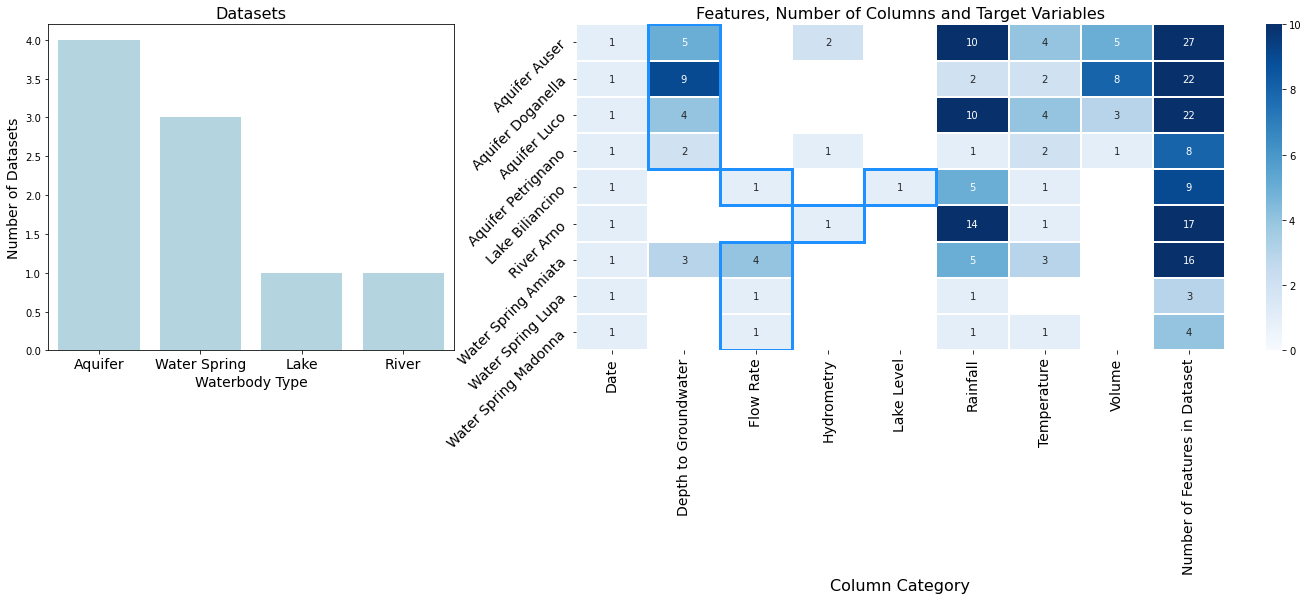

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re
from sklearn import preprocessing
from datetime import datetime, date

import matplotlib.cm as cm
from geopy.geocoders import Nominatim
import folium
from tqdm import tqdm 

from math import radians, cos, sin, asin, sqrt
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc
import lightgbm as lgb



PATH = "../input/acea-water-prediction/"
aquifer_auser_df = pd.read_csv(f"{PATH}Aquifer_Auser.csv")
aquifer_doganella_df = pd.read_csv(f"{PATH}Aquifer_Doganella.csv")
aquifer_luco_df = pd.read_csv(f"{PATH}Aquifer_Luco.csv")
aquifer_petrignano_df = pd.read_csv(f"{PATH}Aquifer_Petrignano.csv")

lake_biliancino_df = pd.read_csv(f"{PATH}Lake_Bilancino.csv")

river_arno_df = pd.read_csv(f"{PATH}River_Arno.csv")

water_spring_amiata_df = pd.read_csv(f"{PATH}Water_Spring_Amiata.csv")
water_spring_lupa_df = pd.read_csv(f"{PATH}Water_Spring_Lupa.csv")
water_spring_madonna_df = pd.read_csv(f"{PATH}Water_Spring_Madonna_di_Canneto.csv")

datasets = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if '.csv' in filename:
            datasets += list([filename])

datasets_df = pd.DataFrame(columns=['filename'], data=datasets)
datasets_df['waterbody_type'] = datasets_df.filename.apply(lambda x: x.split('_')[0])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6),  gridspec_kw={'width_ratios': [1,2]})

sns.countplot(datasets_df.waterbody_type, palette=['lightblue'], ax= ax[0])
ax[0].set_title('Datasets', fontsize=16)
ax[0].set_ylabel('Number of Datasets', fontsize=14)
ax[0].set_xlabel('Waterbody Type', fontsize=14)

ax[0].set_xticklabels(labels=['Aquifer', 'Water Spring', 'Lake', 'River'], fontsize=14)



def get_column_category(x):
    if 'Date' in x:
        return 'Date'
    elif 'Rainfall' in x:
        return 'Rainfall'
    elif 'Depth' in x:
        return 'Depth to Groundwater'
    elif 'Temperature' in x:
        return 'Temperature'
    elif 'Volume' in x:
        return 'Volume'
    elif 'Hydrometry' in x:
        return 'Hydrometry'
    elif 'Lake_Level' in x:
        return 'Lake Level'
    elif 'Flow_Rate' in x:
        return 'Flow Rate'
    else:
        return x

temp_df = pd.DataFrame({'column_name' : aquifer_auser_df.columns, 'waterbody_type':'Aquifer Auser'})
temp_df = temp_df.append(pd.DataFrame({'column_name' : aquifer_doganella_df.columns, 'waterbody_type':'Aquifer Doganella'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : aquifer_luco_df.columns, 'waterbody_type':'Aquifer Luco'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : aquifer_petrignano_df.columns, 'waterbody_type':'Aquifer Petrignano'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : lake_biliancino_df.columns, 'waterbody_type':'Lake Biliancino'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : river_arno_df.columns, 'waterbody_type':'River Arno'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : water_spring_amiata_df.columns, 'waterbody_type':'Water Spring Amiata'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : water_spring_lupa_df.columns, 'waterbody_type':'Water Spring Lupa'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : water_spring_madonna_df.columns, 'waterbody_type':'Water Spring Madonna'}))

temp_df['column_category'] = temp_df.column_name.apply(lambda x: get_column_category(x))

temp_df = temp_df.groupby('waterbody_type').column_category.value_counts().to_frame()
temp_df.columns = ['counts']
temp_df = temp_df.reset_index(drop=False)
temp_df = temp_df.pivot(index='waterbody_type', columns='column_category')['counts']
temp_df['Number of Features in Dataset'] = temp_df.sum(axis=1)

sns.heatmap(temp_df, cmap='Blues', linewidth=1, ax=ax[1], vmin=0, vmax=10, annot=True)

#ax[1].set_ylabel('Waterbody Type', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_xlabel('Column Category', fontsize=16)
ax[1].set_title('Features, Number of Columns and Target Variables', fontsize=16)
ax[1].add_patch(Rectangle((1, 0), 1, 4, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((2, 4), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((4, 4), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((3, 5), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((2, 6), 1, 3, fill=False, alpha=1, color='dodgerblue', lw=3))
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    #tick.label.set_rotation('horizontal')
    tick.label.set_rotation(45) 

plt.show()
plt.show()

Aquifers have 4 common features. Aquifer Petrignano and Auser additionally have the hydrometry feature.
**Water Spring Lupa only has two features** for one target variable. The other water springs additionally have the temperature feature and water spring Amiata also has the depth to groundwater feature.


* **Date**: Uniquely identifies a day
* **Rainfall**: quantity of rain falling in the area (mm)
* **Temperature**: temperature detected by the thermometric station (°C)
* **Depth to Groundwater**: groundwater level detected by the piezometer (m from the ground floor)
* **Flow Rate (water spring/aquifer)**: flow rate  (l/s)
* **Flow Rate (lake)**: flow rate ($m^3$/s)
* **Hydrometry**: groundwater level detected by the hydrometric station (m)
* **Lake Level**: river level (m)
* **Volume**: volume of water taken from the drinking water treatment plant ($m^3$)

In [2]:
# Dropping Rows with Full NaN Values
def drop_nan_rows(df):
    columns = [c for c in df.columns if c != 'Date']
    df_mod = df[columns]
    df_mod.dropna(axis = 0, how = 'all', inplace = True)
    df_mod['Date'] = df['Date']
    print(f"Dropped {len(df)-len(df_mod)} rows")
    return df_mod

#aquifer_auser_df = drop_nan_rows(aquifer_auser_df)
aquifer_doganella_df = drop_nan_rows(aquifer_doganella_df)
#aquifer_luco_df = drop_nan_rows(aquifer_luco_df)
#aquifer_petrignano_df = drop_nan_rows(aquifer_petrignano_df)
#lake_biliancino_df = drop_nan_rows(lake_biliancino_df)
river_arno_df = drop_nan_rows(river_arno_df)
#water_spring_amiata_df = drop_nan_rows(water_spring_amiata_df)
#water_spring_lupa_df = drop_nan_rows(water_spring_lupa_df)
water_spring_madonna_df = drop_nan_rows(water_spring_madonna_df)

Dropped 4 rows
Dropped 45 rows
Dropped 48 rows


In [3]:
waterbodies_df = aquifer_auser_df.merge(aquifer_doganella_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(aquifer_luco_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(aquifer_petrignano_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(lake_biliancino_df[['Date','Temperature_Le_Croci','Lake_Level', 'Flow_Rate']], on='Date', how='outer') # Only merge specific columns because 'Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci' are shared with river_arno_df
waterbodies_df = waterbodies_df.merge(river_arno_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(water_spring_amiata_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(water_spring_lupa_df, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(water_spring_madonna_df, on='Date', how='outer')

waterbodies_df['Date_dt'] = pd.to_datetime(waterbodies_df.Date, format = '%d/%m/%Y')
waterbodies_df = waterbodies_df.sort_values(by='Date_dt').reset_index(drop=True)
waterbodies_df

Date  Rainfall_Gallicano  Rainfall_Pontetetto  \
0     01/01/1998                 NaN                  NaN   
1     02/01/1998                 NaN                  NaN   
2     03/01/1998                 NaN                  NaN   
3     04/01/1998                 NaN                  NaN   
4     05/01/1998                 NaN                  NaN   
...          ...                 ...                  ...   
8212  26/06/2020                 0.0                  0.0   
8213  27/06/2020                 0.0                  0.0   
8214  28/06/2020                 0.0                  0.0   
8215  29/06/2020                 0.0                  0.0   
8216  30/06/2020                 0.0                  0.0   

      Rainfall_Monte_Serra  Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  \
0                      NaN                NaN                       NaN   
1                      NaN                NaN                       NaN   
2                      NaN                NaN                       NaN   
3                      NaN                NaN                       NaN   
4                      NaN                NaN                       NaN   
...                    ...                ...                       ...   
8212                   0.0                0.0                       0.0   
8213                   0.0                0.0                       0.0   
8214                   0.0                0.0                       0.0   
8215                   0.0                0.0                       0.0   
8216                   0.0                0.0                       0.0   

      Rainfall_Piaggione  Rainfall_Calavorno  Rainfall_Croce_Arcana  \
0                    NaN                 NaN                    NaN   
1                    NaN                 NaN                    NaN   
2                    NaN                 NaN                    NaN   
3                    NaN                 NaN                    NaN   
4                    NaN                 NaN                    NaN   
...                  ...                 ...                    ...   
8212                 0.0                 0.0                    0.0   
8213                 0.0                 0.0                    0.0   
8214                 0.0                 0.0                    0.0   
8215                 0.0                 0.0                    0.0   
8216                 0.0                 0.0                    0.0   

      Rainfall_Tereglio_Coreglia_Antelminelli  ...  Flow_Rate_Bugnano  \
0                                         NaN  ...                NaN   
1                                         NaN  ...                NaN   
2                                         NaN  ...                NaN   
3                                         NaN  ...                NaN   
4                                         NaN  ...                NaN   
...                                       ...  ...                ...   
8212                                      0.0  ...          -0.359942   
8213                                      0.0  ...          -0.359942   
8214                                      0.0  ...          -0.341945   
8215                                      0.0  ...          -0.359942   
8216                                      0.0  ...          -0.359942   

      Flow_Rate_Arbure  Flow_Rate_Ermicciolo  Flow_Rate_Galleria_Alta  \
0                  NaN                   NaN                      NaN   
1                  NaN                   NaN                      NaN   
2                  NaN                   NaN                      NaN   
3                  NaN                   NaN                      NaN   
4                  NaN                   NaN                      NaN   
...                ...                   ...                      ...   
8212         -2.925253              -5.75661               -21.358856   
8213         -2.925253              -5.75661               -21.3


## Target Variables
First, we will look at the target variables. We are provided with time series data and we are asked to build models to predict the target variables for a set time unit. Therefore, let's have a look at the target variables over time. 

In general, there are quite a bit of missing values and some data points seem implausible.

The target variables for the **aquifers** is the 'Depth to Groundwater' of a well. **Note that not all columns called 'Depth to Groundwater' are target variables** (e.g. `Depth_to_Groundwater_PAG` and a few more). The depth to groundwater is a negative value with seems to have a seasonal component. 
Wells P24 and P25 seem to be strongly correlated. Before 2006, there is no data available for the target variables.

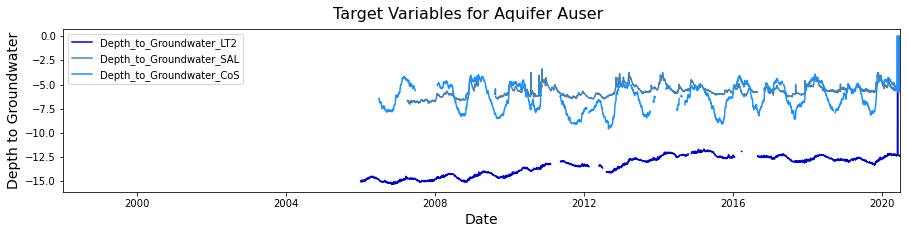

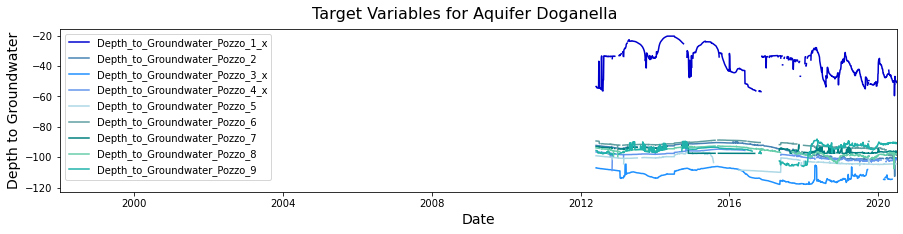

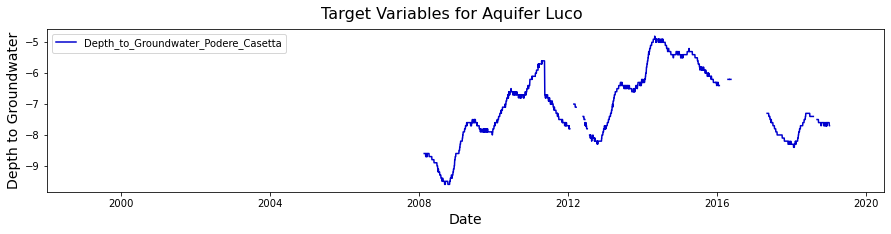

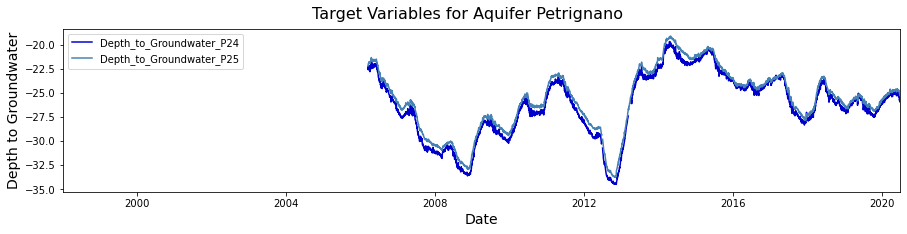

In [4]:
n_targets = 1
height=3

custom_colors = ['mediumblue', 'steelblue', 'dodgerblue', 'cornflowerblue', 'lightblue', 
                 'cadetblue', 'teal', 'mediumaquamarine', 'lightseagreen']
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Auser', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', ]): # 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_DIEC']): not targets
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Doganella', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_Pozzo_1_x', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3_x', 'Depth_to_Groundwater_Pozzo_4_x',
               'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8',
              'Depth_to_Groundwater_Pozzo_9']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Luco', fontsize=16)
for i, target in enumerate(['Depth_to_Groundwater_Podere_Casetta',]): # 'Depth_to_Groundwater_Pozzo_1_y', 'Depth_to_Groundwater_Pozzo_3_y', 'Depth_to_Groundwater_Pozzo_4_y']): not targets
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Petrignano', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

**River** Arno is the only waterbody in its category. It has the target variable 'Hydrometry', which is a positive value with a seasonal component. There is data available from 1998.



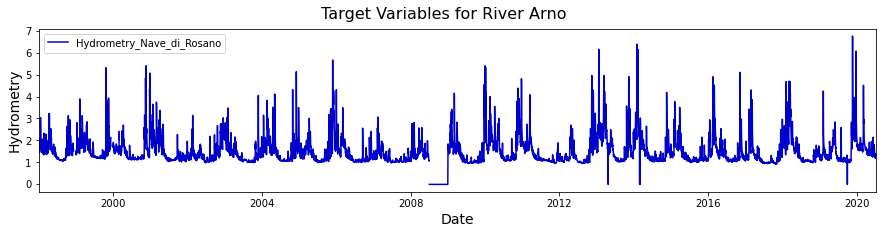

In [5]:
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for River Arno', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Hydrometry_Nave_di_Rosano.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0], label='Hydrometry_Nave_di_Rosano')
ax.set_ylabel('Hydrometry', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

**Lake** Biliancino is also the only waterbody in its category. It has two target variables 'Lake Level' and 'Flow Rate'. Both variables have a positive value with a seasonal component. There is data available from 2002.




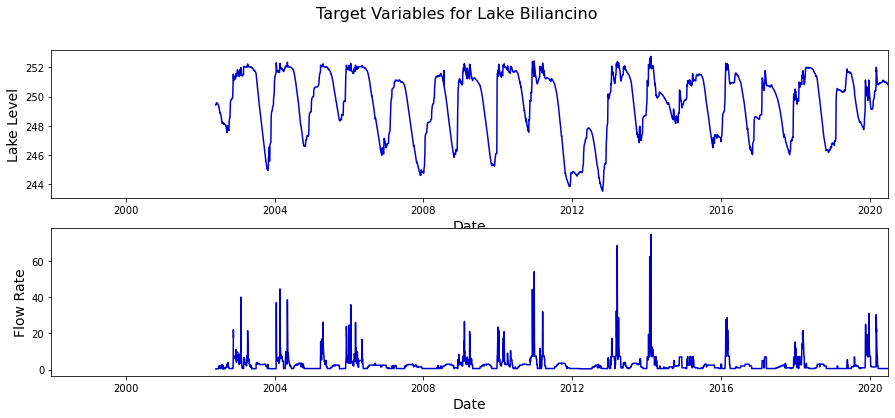

In [6]:
n_targets = 2
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Lake Biliancino', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Lake_Level.replace({np.nan : np.inf}), ax=ax[0], color=custom_colors[0])
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate.replace({np.nan : np.inf}), ax=ax[1], color=custom_colors[0])
ax[0].set_ylabel('Lake Level', fontsize=14)
ax[1].set_ylabel('Flow Rate', fontsize=14)

for i in range(n_targets):
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

The target variables for the **water spring** is the 'Flow Rate'. According to the [Discussion: For all attendees - Negative Flow rate](https://www.kaggle.com/c/acea-water-prediction/discussion/205071), we have to only consider the absolute value:

> [...] it is necessary to consider the absolute value without the + or - sign for flow rate. Originally the minus sign (-) was meant to indicate the output water from the waterbody (water extracted from the waterbody) while the plus sign (+) was meant to indicate the input water to the waterbody. [...] it is necessary to consider only the absolute value.

The data for Water Spring Lupa and Madonna di Canneto makes a bad first impression in regards to data quality. We will have to analyse this in depth.
Before 2009, there is no data available for the target variables.


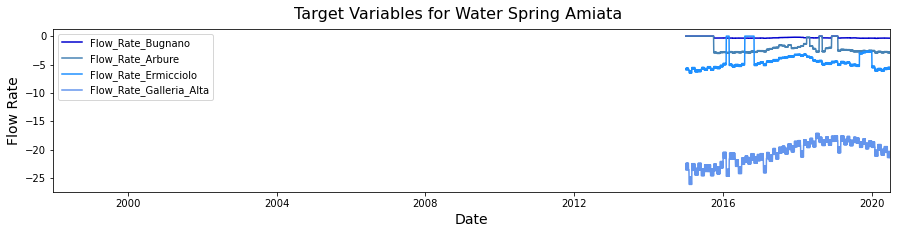

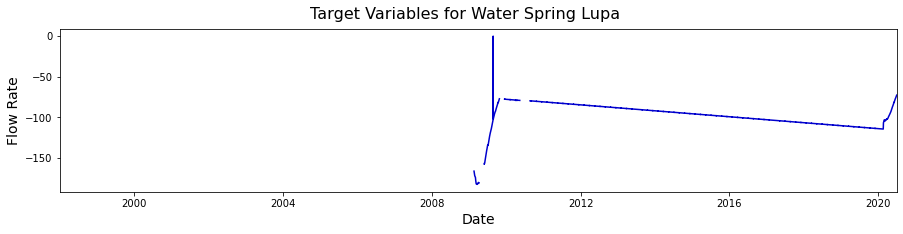

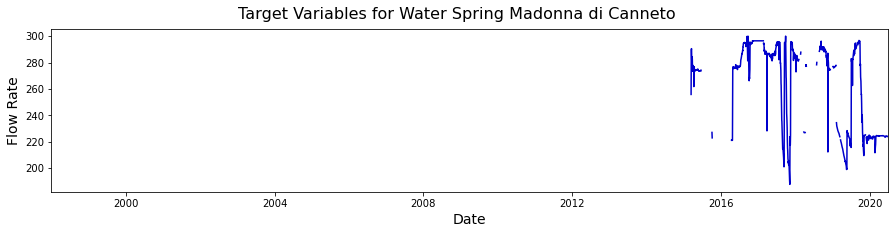

In [7]:
n_targets = 1
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Amiata', fontsize=16)

for i, target in enumerate(['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Lupa', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate_Lupa.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0])

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Madonna di Canneto', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate_Madonna_di_Canneto.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0])

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

# Preprocessing

## Take Absolute Value of Flow Rate

As mentioned above, we have to consider only the absolute values (see [Discussion: For all attendees - Negative Flow rate](https://www.kaggle.com/c/acea-water-prediction/discussion/205071)).

In [8]:
waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Flow')]] = np.abs(waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Flow')]])

## Unify Unit for Flow Rate
From the datasets_description.ods file, we know that the unit of the lake's flow rate is $m^3/s$ while the unit for aqufiers' and water springs' flow rate is $l/s$. Let's scale the lake's flow rate to $l/s$ as well. There are 1000l in 1$m^3$.

In [9]:
waterbodies_df['Flow_Rate'] = waterbodies_df['Flow_Rate']*1000

## Remove Duplicate Features
The datasets for Lake Biliancino and River Arno share the column names `Rainfall_S_Piero`, `Rainfall_Mangona`, `Rainfall_S_Agata`, `Rainfall_Cavallina`, and `Rainfall_Le_Croci`. These columns also **share the same values**. Therefore, we can assume that these are duplicates.

The datasets for Aquifer Doganella and Aquifer Luco share the column names `Depth_to_Groundwater_Pozzo_1`, `Depth_to_Groundwater_Pozzo_3`, `Depth_to_Groundwater_Pozzo_4`, `Volume_Pozzo_1`, `Volume_Pozzo_3` and `Volume_Pozzo_4`. These columns **do not share the same values**. Therefore, we can assume that these are not duplicates.


In [10]:
print("Feature Rainfall_S_Piero is a duplicate: ", 
      river_arno_df[river_arno_df.Date.isin(lake_biliancino_df.Date.unique()) & river_arno_df.Rainfall_S_Piero.notna()]['Rainfall_S_Piero'].reset_index(drop=True)\
        .equals(lake_biliancino_df[lake_biliancino_df.Rainfall_S_Piero.notna()]['Rainfall_S_Piero'].reset_index(drop=True)))

print("Feature Rainfall_Mangona is a duplicate: ", 
      river_arno_df[river_arno_df.Date.isin(lake_biliancino_df.Date.unique()) & river_arno_df.Rainfall_Mangona.notna()]['Rainfall_Mangona'].reset_index(drop=True)\
        .equals(lake_biliancino_df[lake_biliancino_df.Rainfall_Mangona.notna()]['Rainfall_Mangona'].reset_index(drop=True)))

print("Feature Rainfall_S_Agata is a duplicate: ", 
      river_arno_df[river_arno_df.Date.isin(lake_biliancino_df.Date.unique()) & river_arno_df.Rainfall_S_Agata.notna()]['Rainfall_S_Agata'].reset_index(drop=True)\
        .equals(lake_biliancino_df[lake_biliancino_df.Rainfall_S_Agata.notna()]['Rainfall_S_Agata'].reset_index(drop=True)))

print("Feature Rainfall_Cavallina is a duplicate: ", 
      river_arno_df[river_arno_df.Date.isin(lake_biliancino_df.Date.unique()) & river_arno_df.Rainfall_Cavallina.notna()]['Rainfall_Cavallina'].reset_index(drop=True)\
        .equals(lake_biliancino_df[lake_biliancino_df.Rainfall_Cavallina.notna()]['Rainfall_Cavallina'].reset_index(drop=True)))

print("Feature Rainfall_Le_Croci is a duplicate: ", 
      river_arno_df[river_arno_df.Date.isin(lake_biliancino_df.Date.unique()) & river_arno_df.Rainfall_Le_Croci.notna()]['Rainfall_Le_Croci'].reset_index(drop=True)\
        .equals(lake_biliancino_df[lake_biliancino_df.Rainfall_Le_Croci.notna()]['Rainfall_Le_Croci'].reset_index(drop=True)))

print("Feature Depth_to_Groundwater_Pozzo_1 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Depth_to_Groundwater_Pozzo_1.notna()]['Depth_to_Groundwater_Pozzo_1'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Depth_to_Groundwater_Pozzo_1.notna()]['Depth_to_Groundwater_Pozzo_1'].reset_index(drop=True)))

print("Feature Depth_to_Groundwater_Pozzo_3 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Depth_to_Groundwater_Pozzo_3.notna()]['Depth_to_Groundwater_Pozzo_3'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Depth_to_Groundwater_Pozzo_3.notna()]['Depth_to_Groundwater_Pozzo_3'].reset_index(drop=True)))

print("Feature Depth_to_Groundwater_Pozzo_4 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Depth_to_Groundwater_Pozzo_4.notna()]['Depth_to_Groundwater_Pozzo_4'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Depth_to_Groundwater_Pozzo_4.notna()]['Depth_to_Groundwater_Pozzo_4'].reset_index(drop=True)))

print("Feature Volume_Pozzo_1 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Volume_Pozzo_1.notna()]['Volume_Pozzo_1'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Volume_Pozzo_1.notna()]['Volume_Pozzo_1'].reset_index(drop=True)))

print("Feature Volume_Pozzo_3 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Volume_Pozzo_3.notna()]['Volume_Pozzo_3'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Volume_Pozzo_3.notna()]['Volume_Pozzo_3'].reset_index(drop=True)))

print("Feature Volume_Pozzo_4 is a duplicate: ", 
      aquifer_doganella_df[aquifer_doganella_df.Date.isin(aquifer_luco_df.Date.unique()) & aquifer_doganella_df.Volume_Pozzo_4.notna()]['Volume_Pozzo_4'].reset_index(drop=True)\
        .equals(aquifer_luco_df[aquifer_luco_df.Volume_Pozzo_4.notna()]['Volume_Pozzo_4'].reset_index(drop=True)))

Feature Rainfall_S_Piero is a duplicate:  True
Feature Rainfall_Mangona is a duplicate:  True
Feature Rainfall_S_Agata is a duplicate:  True
Feature Rainfall_Cavallina is a duplicate:  True
Feature Rainfall_Le_Croci is a duplicate:  True
Feature Depth_to_Groundwater_Pozzo_1 is a duplicate:  False
Feature Depth_to_Groundwater_Pozzo_3 is a duplicate:  False
Feature Depth_to_Groundwater_Pozzo_4 is a duplicate:  False
Feature Volume_Pozzo_1 is a duplicate:  False
Feature Volume_Pozzo_3 is a duplicate:  False
Feature Volume_Pozzo_4 is a duplicate:  False


## Handling Missing Data
We can see that there is a lot of missing data in the merged dataset. 

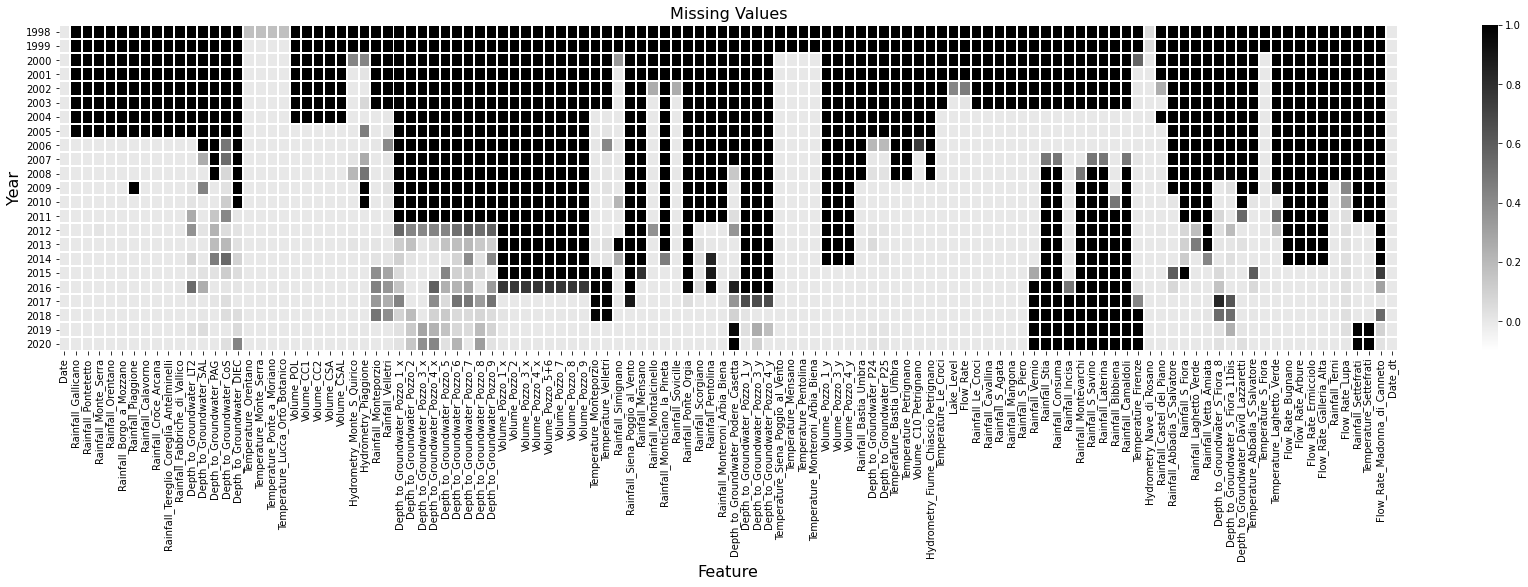

In [11]:
waterbodies_df['year'] = waterbodies_df.Date.apply(lambda x: x.split('/')[2] if x==x else x)
waterbodies_df['year'] = waterbodies_df['year'].astype(int)

temp = waterbodies_df[[c for c in waterbodies_df.columns if c != 'year']].isna().astype(int)
temp['year'] = waterbodies_df.year
temp = temp.groupby('year').mean()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,6))

sns.heatmap(temp,  
            cmap='binary', vmin=-0.1, vmax=1, ax=ax, linewidth=1)#[0])
ax.set_ylabel('Year', fontsize=16)
ax.set_xlabel('Feature', fontsize=16)
ax.set_title('Missing Values', fontsize=16)

plt.show()

### Drop Very Old Data
For simplification reasons, we will drop all data before 2000 since there are only 5 features available. Losing the data is 1998 and 1999 is not evaluated as cricital since there is still 20 years of data left.

In [12]:
waterbodies_df = waterbodies_df[waterbodies_df.year>= 2000].reset_index(drop=True)

### Temperature: Imputing Data by Prediction
From below plot, we can see that the temperaturecolumns have a lot of missing values (NaN). Also, we can see that there are a lot of **implausible temperature values of 0°C**. We will replace the implausible zero values with NaN if there are two or more consecutive days with 0°C.

TODO: Maybe add a seasonal check as well to improve NaN replacement for implausible zero values.

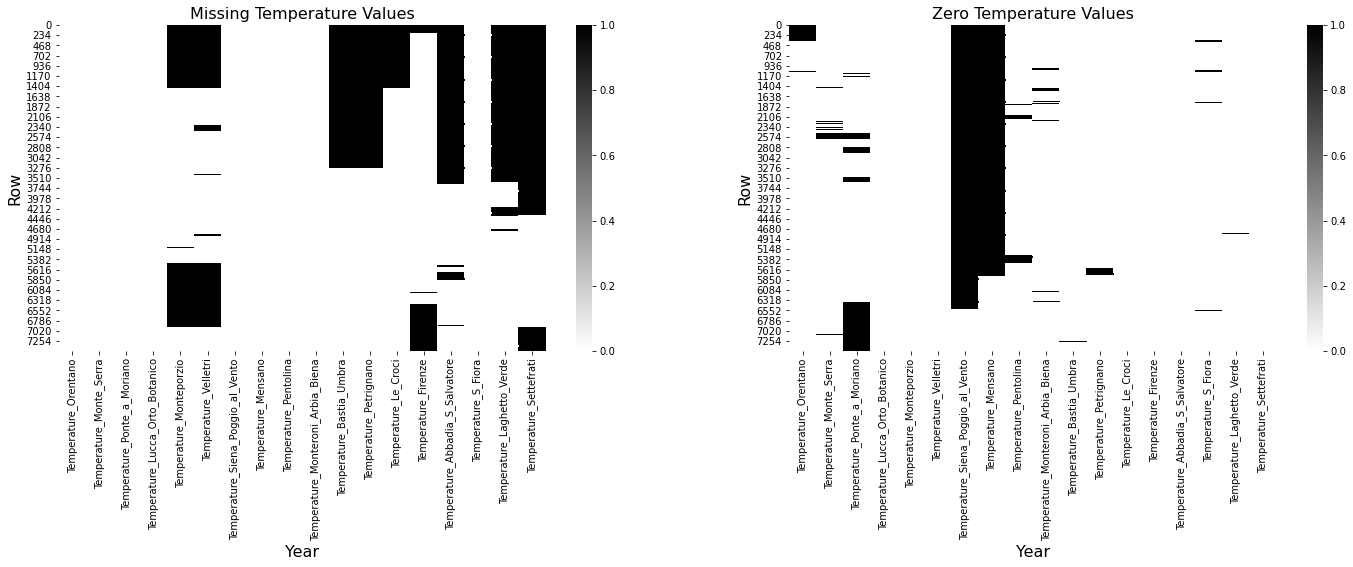

In [13]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6))

sns.heatmap(waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Temperature')]].isna().astype(int),  
            cmap='binary', linewidth=0, vmin=0, vmax=1, ax=ax[0])
ax[0].set_ylabel('Row', fontsize=16)
ax[0].set_xlabel('Year', fontsize=16)
ax[0].set_title('Missing Temperature Values', fontsize=16)

sns.heatmap((waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Temperature')]] == 0).astype(int),  
            cmap='binary', linewidth=0, vmin=0, vmax=1, ax=ax[1])
ax[1].set_ylabel('Row', fontsize=16)
ax[1].set_xlabel('Year', fontsize=16)
ax[1].set_title('Zero Temperature Values', fontsize=16)

plt.show()

In [14]:
def replace_implausible_zeros(col):
    temp_col = waterbodies_df[[col]].copy()
    temp_col['key'] = (temp_col[col] != temp_col[col].shift(1)).astype(int).cumsum()
    key_dict = temp_col.groupby(['key']).agg({col : 'mean', 'key':'count'})
    key_dict = key_dict[(key_dict[col]==0) & (key_dict.key >2)]
    for key in key_dict.index:
        temp_col[col] = np.where(temp_col['key'] == key, np.nan, temp_col[col]) 
    return temp_col[col]

temperature_cols = waterbodies_df.columns[waterbodies_df.columns.str.startswith('Temperature')]

for col in temperature_cols:
    waterbodies_df[col] = replace_implausible_zeros(col)

As a preprocessing step of the data, we will fill the NaN values and replace the implausible values as well.
First, the implausible values of 0°C will be replaced with NaN values. Then all NaN values will be filled by prediction. For this, we will build a small prediction model.

We will be using LightGBM with a 5 fold CV. The features are the temperature columns as well as the date features.
Although, the mean absolute error is quite high for the below shown example, we can see that the rolling mean for the predicted values is very close to the rolling mean of the ground truth. Although the models performance is not very good, we can evaluate it as sufficient for filling the missing values.

(Work in progress: Maybe utilize above clusters as a second model to improve prediction)

Below you can see one example for `Temperature_Velletri`. For the other imputed temperature columns, please expande the hidden output.

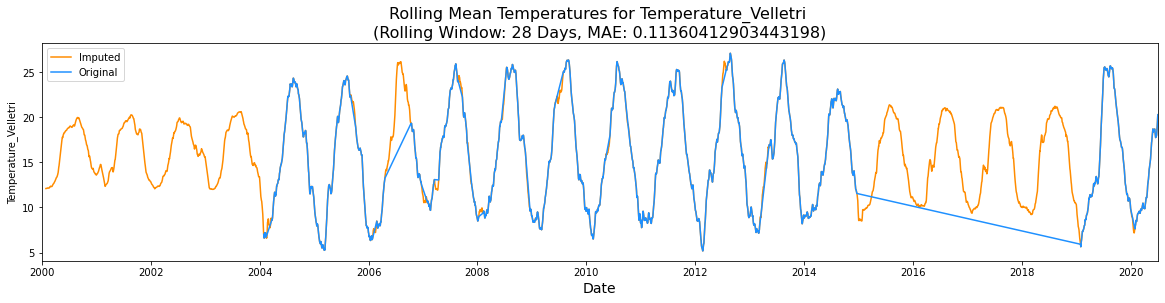

In [15]:
def get_time_features(df):
    df['year'] = df.Date.apply(lambda x: x.split('/')[2] if x==x else x)
    df['month'] = df.Date.apply(lambda x: x.split('/')[1]if x==x else x)
    df['day_in_year'] = df.Date.apply(lambda x: datetime(int(x.split('/')[2]), int(x.split('/')[1]), int(x.split('/')[0]), 0, 0).timetuple().tm_yday if x==x else x)
    df['week_in_year'] = df.day_in_year.apply(lambda x: int(x/7) if x==x else x)
    return df

waterbodies_df = get_time_features(waterbodies_df)
waterbodies_df.month = waterbodies_df.month.astype(int)
waterbodies_df.year = waterbodies_df.year.astype(int)

params = {'num_leaves': 24,
          'objective': 'regression_l1',
          'max_depth': 8,
          'learning_rate': 0.01,
          "metric": 'mae',
          "verbosity": -1,
          'verbose': -1,
          'seed' : 42
         }

def predict_missing_temperature(target):
    """
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    ax.set_title(f'Temperatures for {target}', fontsize=16)

    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target], label=target, )
    sns.scatterplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].isna().apply(lambda x: 15 if x else np.nan), color='red', linewidth=0, label='To predict' )
    ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
    plt.show()
    """

    test_df = waterbodies_df.copy()
    train_df = waterbodies_df[waterbodies_df[target].notna()]

    features = [c for c in (list(temperature_cols) + list(['month', 'day_in_year', 'week_in_year'])) if c != target]

    X = train_df[features]
    y = train_df[[target]]
    X_test = test_df[features]

    y_preds = np.zeros(X_test.shape[0])

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dtrain = lgb.Dataset(X_train, y_train, params= {'verbose': -1})
    dvalid = lgb.Dataset(X_valid, y_valid, params= {'verbose': -1})

    # For analysis set 'verbose_eval' to 200, false
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=False,  early_stopping_rounds=100)

    y_pred_valid = clf.predict(X_valid)
    y_preds = clf.predict(X_test)
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    ax.set_title(f'Rolling Mean Temperatures for {target} \n(Rolling Window: 28 Days, MAE: {mean_absolute_error(y_valid.rolling(28).mean()[28:], pd.Series(y_pred_valid).rolling(28).mean()[28:])})', fontsize=16)
    old = waterbodies_df[target].copy().replace({np.nan : np.inf})
    waterbodies_df[target] = np.where(waterbodies_df[target].isna(), pd.Series(y_preds), waterbodies_df[target])
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].rolling(28).mean(), label='Imputed', color='darkorange')
    sns.lineplot(x=waterbodies_df.Date_dt, y=old.rolling(28).mean(), label='Original', color='dodgerblue')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
    plt.show()
    #return pd.Series(y_preds)

# Sort temperature columns according to amount of missing values.
# Fill NaN values for features with least missing values first
sorted_temperature_cols = waterbodies_df[temperature_cols].isna().sum(axis=0).sort_values().index

example_col = 'Temperature_Velletri'
predict_missing_temperature(example_col)



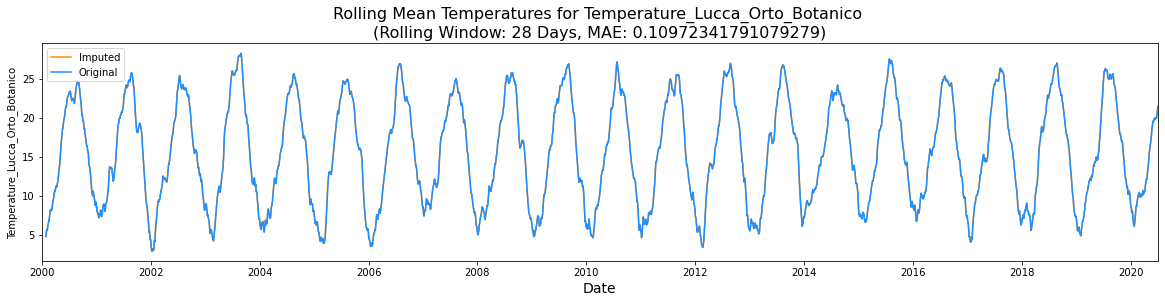

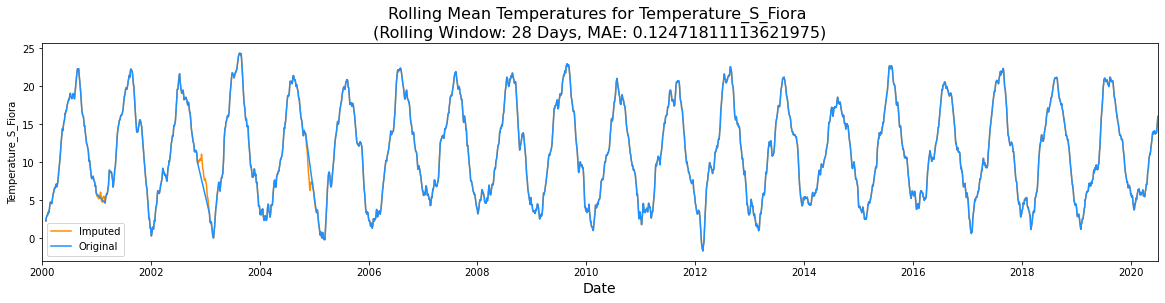

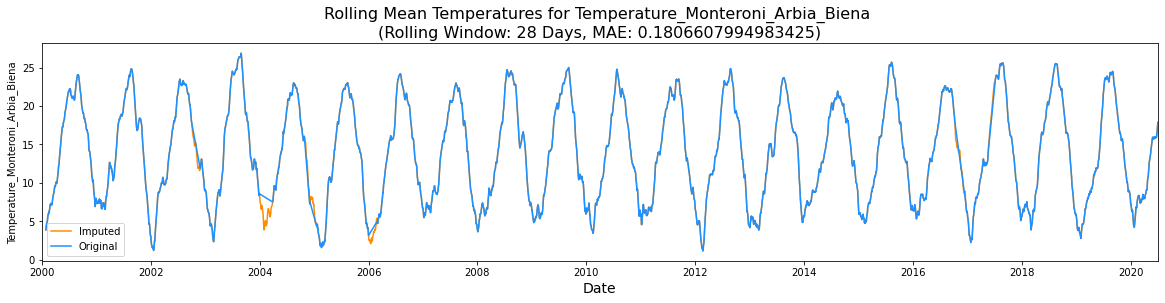

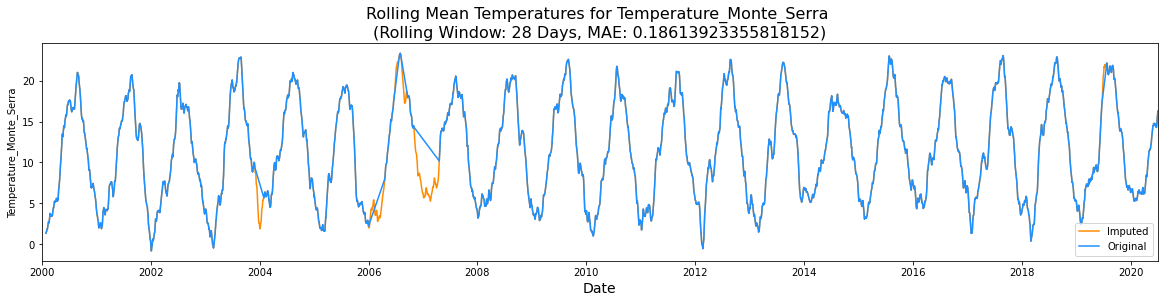

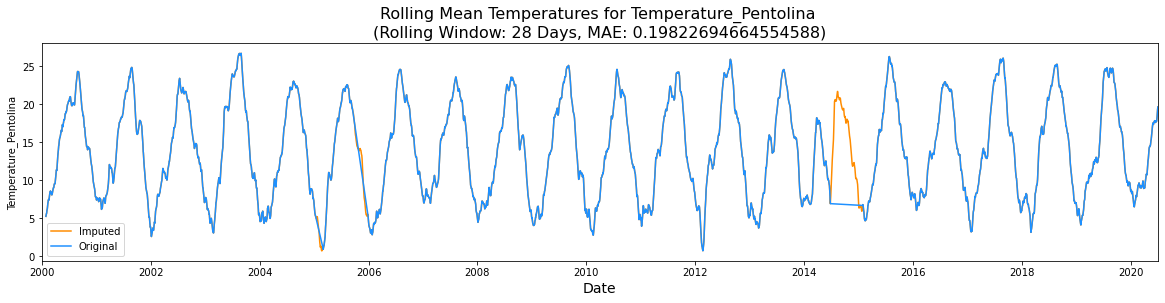

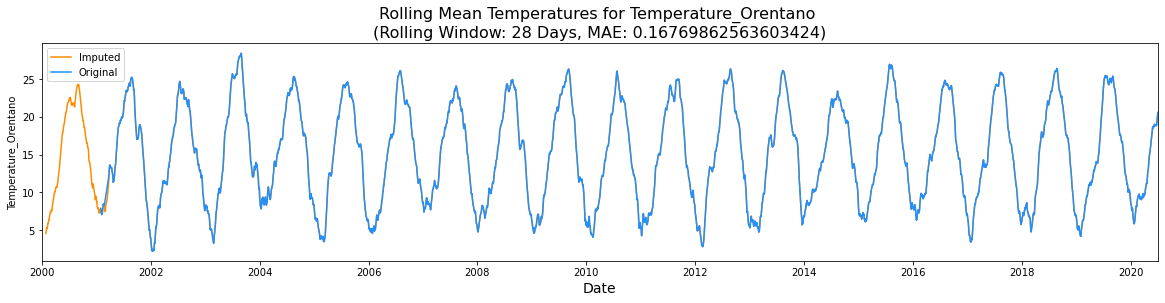

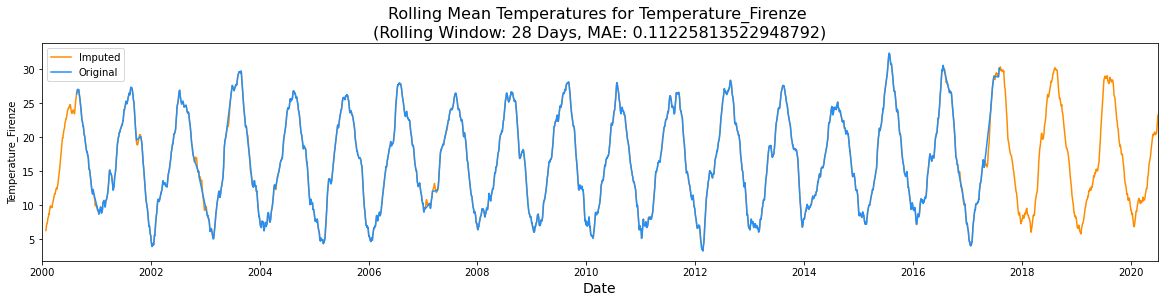

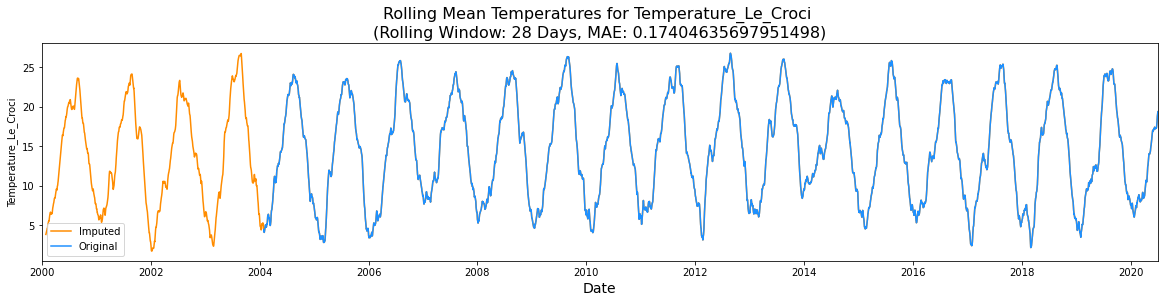

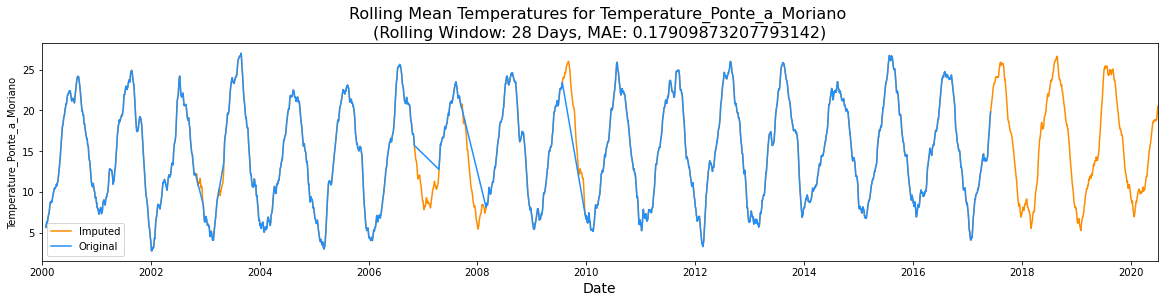

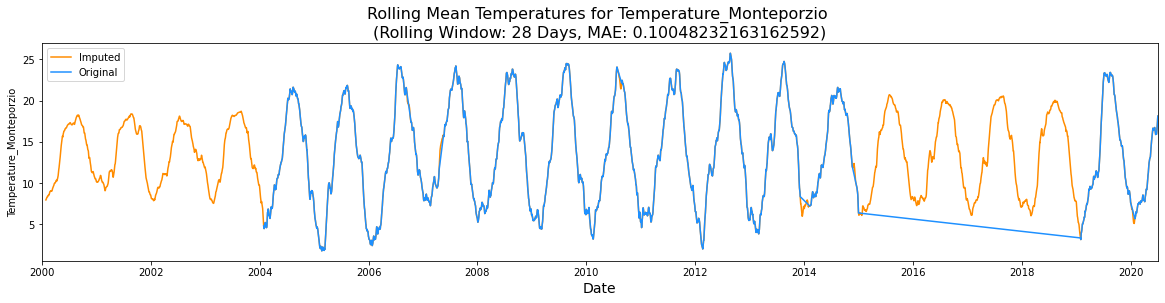

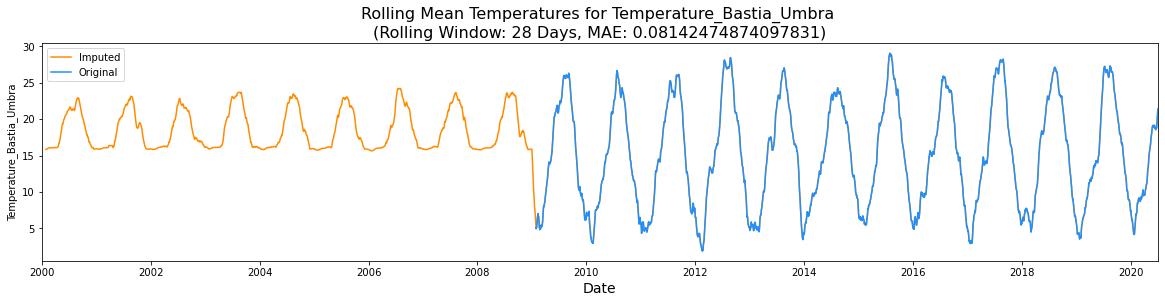

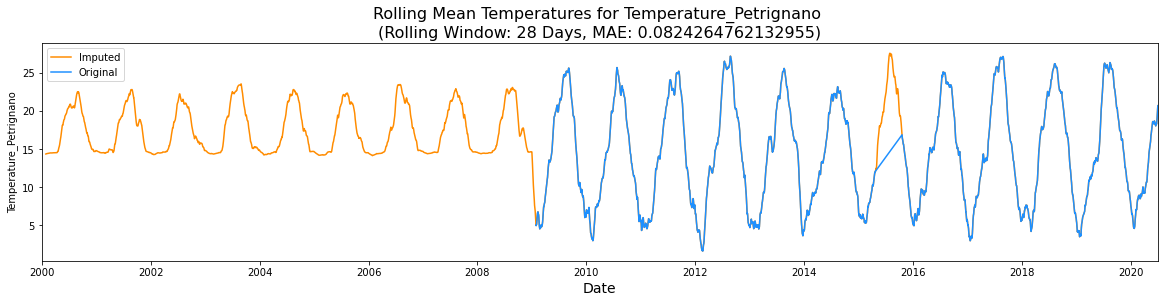

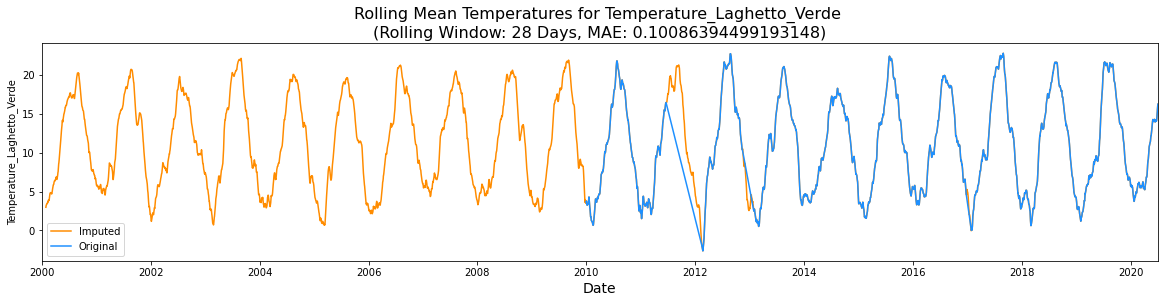

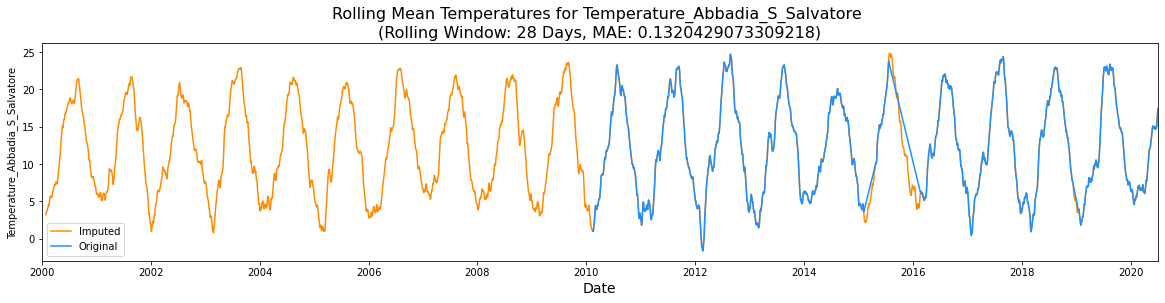

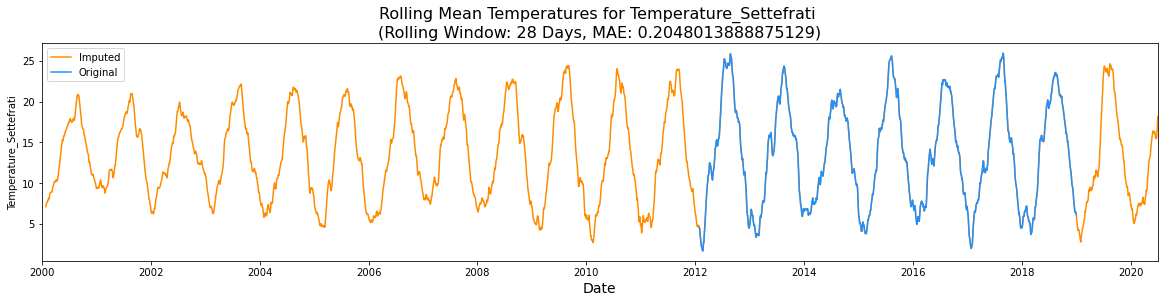

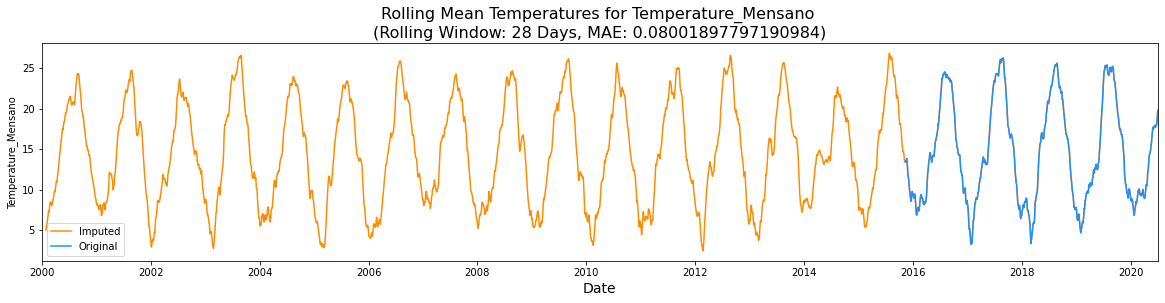

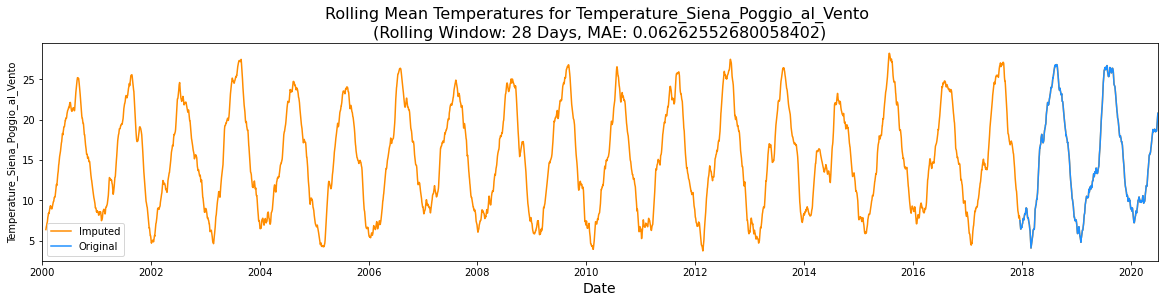

In [16]:
for col in sorted_temperature_cols:
    if col != example_col:
        predict_missing_temperature(col)

TODO: Improve predictions for `Temperature_Bastia_Umbra` and `Temperature_Petrignano`.

### Depth to Groundwater: Interpolate Missing Values
For the `Depth to Groundwater` features, there are a lot of missing values in between as we saw in the initial look at the target variables. We cann fill these by interpolating between two data points with the `.interpolate()` function.

Below you can see one example for `Depth_to_Groundwater_S_Fiora_11bis`. For the other imputed temperature columns, please expande the hidden output.

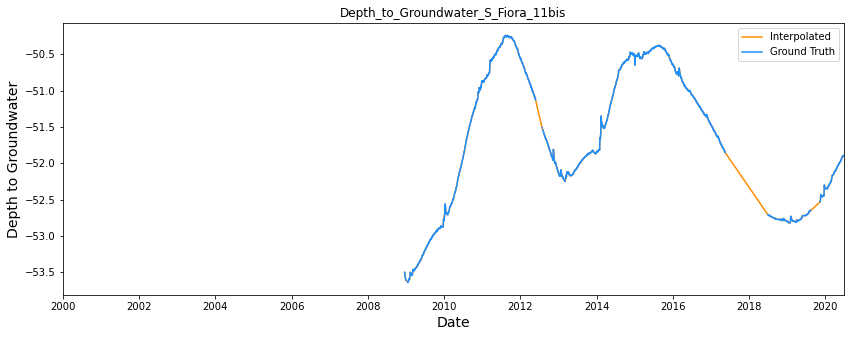

In [17]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
example_cols ='Depth_to_Groundwater_S_Fiora_11bis'
ax.set_title(f'{example_cols}')

sns.lineplot(x=waterbodies_df.Date_dt, y = waterbodies_df[example_cols].interpolate(), color='darkorange', ax=ax, label='Interpolated')
sns.lineplot(x=waterbodies_df.Date_dt, y = waterbodies_df[example_cols].replace({np.nan : np.inf}), color='dodgerblue', ax=ax, label='Ground Truth')
ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
plt.show()

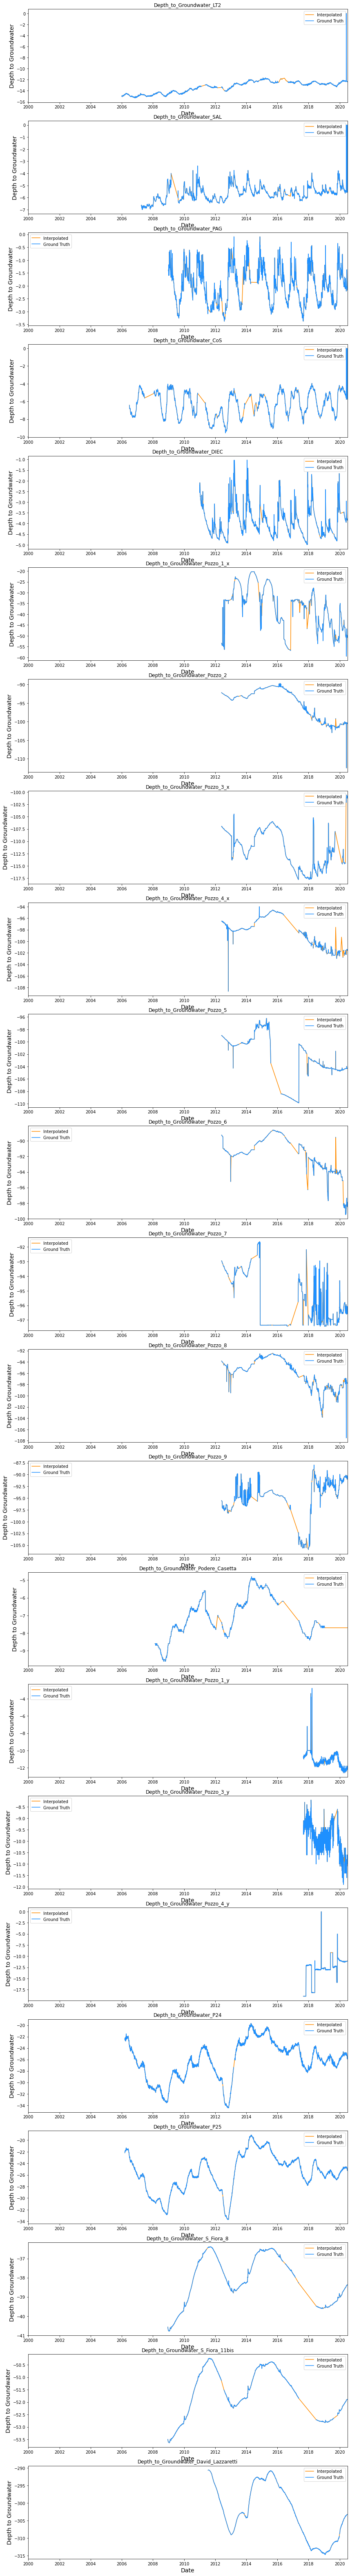

In [18]:
depth_to_groundwater_cols = waterbodies_df.columns[waterbodies_df.columns.str.startswith('Depth_to')]

f, ax = plt.subplots(nrows=len(depth_to_groundwater_cols), ncols=1, figsize=(14, 5*len(depth_to_groundwater_cols)))

for i, col in enumerate(depth_to_groundwater_cols):
    ax[i].set_title(f'{col}')

    sns.lineplot(x=waterbodies_df.Date_dt, y = waterbodies_df[col].interpolate(), color='darkorange', ax=ax[i], label='Interpolated')
    sns.lineplot(x=waterbodies_df.Date_dt, y = waterbodies_df[col].replace({np.nan : np.inf}), color='dodgerblue', ax=ax[i], label='Ground Truth')
    ax[i].set_ylabel('Depth to Groundwater', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
plt.show()

waterbodies_df[depth_to_groundwater_cols] = waterbodies_df[depth_to_groundwater_cols].interpolate()

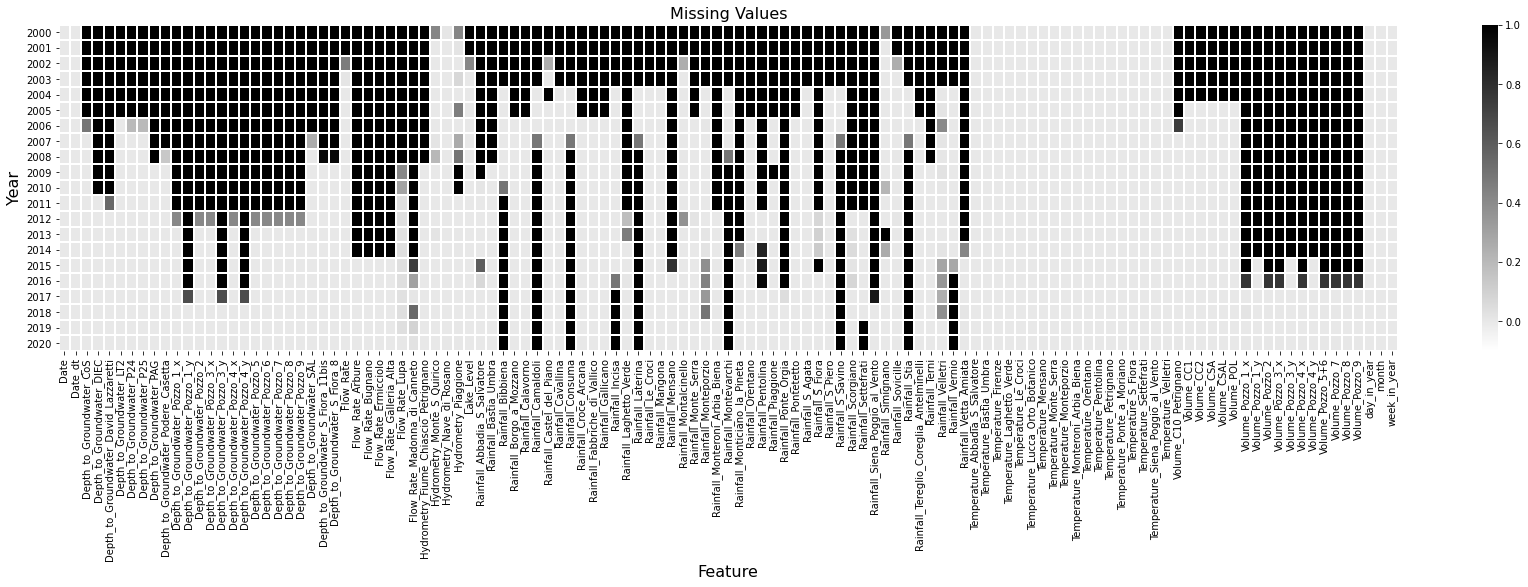

In [19]:
cols = sorted([c for c in waterbodies_df.columns if c != 'year'])
temp = waterbodies_df[cols].isna().astype(int)
temp['year'] = waterbodies_df.year
temp = temp.groupby('year').mean()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,6))

sns.heatmap(temp,  
            cmap='binary', vmin=-0.1, vmax=1, ax=ax, linewidth=1)#[0])
ax.set_ylabel('Year', fontsize=16)
ax.set_xlabel('Feature', fontsize=16)
ax.set_title('Missing Values', fontsize=16)

plt.show()

waterbodies_df = waterbodies_df[waterbodies_df.year>= 2000].reset_index(drop=True)

# Exploratory Data Analysis

In this section, we are going to explore the datasets.

Let's get a feeling about how many years of data we are looking at for each dataset. For the datasets for aquifer Auser, aquifer Luco, river Arno, and water spring Amiata, we have **more than 20 years of data.** On the other side, water spring Madonna only contains information about the past 8 years.

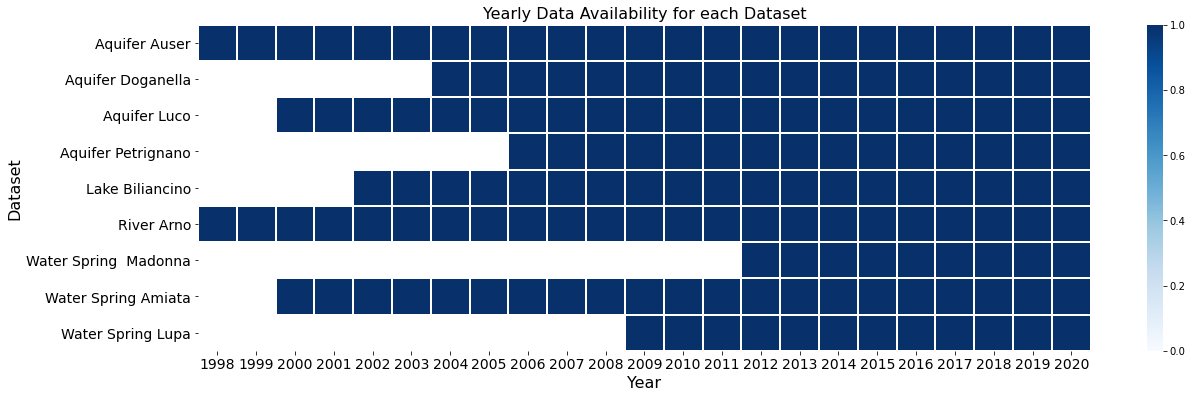

In [20]:

aquifer_auser_df = get_time_features(aquifer_auser_df)
aquifer_doganella_df = get_time_features(aquifer_doganella_df)
aquifer_luco_df = get_time_features(aquifer_luco_df)
aquifer_petrignano_df = get_time_features(aquifer_petrignano_df)
lake_biliancino_df = get_time_features(lake_biliancino_df)
river_arno_df = get_time_features(river_arno_df)
water_spring_amiata_df = get_time_features(water_spring_amiata_df)
water_spring_lupa_df = get_time_features(water_spring_lupa_df)
water_spring_madonna_df = get_time_features(water_spring_madonna_df)


temp_df = (pd.DataFrame({'year' : aquifer_auser_df.year.unique(), 'dataset': 'Aquifer Auser'}))
temp_df = temp_df.append(pd.DataFrame({'year' : aquifer_doganella_df.year.unique(), 'dataset': 'Aquifer Doganella'}))
temp_df = temp_df.append(pd.DataFrame({'year' : aquifer_luco_df.year.unique(), 'dataset': 'Aquifer Luco'}))
temp_df = temp_df.append(pd.DataFrame({'year' : aquifer_petrignano_df.year.unique(), 'dataset': 'Aquifer Petrignano'}))
temp_df = temp_df.append(pd.DataFrame({'year' : lake_biliancino_df.year.unique(), 'dataset': 'Lake Biliancino'}))
temp_df = temp_df.append(pd.DataFrame({'year' : river_arno_df.year.unique(), 'dataset': 'River Arno'}))
temp_df = temp_df.append(pd.DataFrame({'year' : water_spring_amiata_df.year.unique(), 'dataset': 'Water Spring Amiata'}))
temp_df = temp_df.append(pd.DataFrame({'year' : water_spring_lupa_df.year.unique(), 'dataset': 'Water Spring Lupa'}))
temp_df = temp_df.append(pd.DataFrame({'year' : water_spring_madonna_df.year.unique(), 'dataset': 'Water Spring  Madonna'}))

temp_df['dummy'] = 1
temp_df = temp_df[temp_df.year.notna()]
temp_df = temp_df.pivot(index='dataset', columns='year')['dummy']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6))

sns.heatmap(temp_df, cmap='Blues', linewidth=1, ax=ax, vmin=0, vmax=1)


ax.set_ylabel('Dataset', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_title('Yearly Data Availability for each Dataset', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.show()

## Geographical Analysis
Next, let's plot the locations for which we have rainfall and temperature data to get a feeling for the data. For this, we will **gather the coordinates** for each location. You can use [this site](https://www.sir.toscana.it/consistenza-rete) as suggested by the competition host in [Discussion: Features geolocation?](https://www.kaggle.com/c/acea-water-prediction/discussion/202797) for part of the locations.

We can see that lake Bilancino and river Arno contain share a few locations. We have already seen this in the preprocessing step. This is due to the **relationship between the lake Bilancino and the river Arno**. Lake Bilancino is an artificial lake made with a dam on the Sieve river. And the Sieve River is the most important tributary of the Arno river (see [Wikipedia: Lago di Bilancino](https://en.wikipedia.org/wiki/Lago_di_Bilancino), [Wikipedia: Sieve (river)]( https://en.wikipedia.org/wiki/Sieve_(river))).

While there is an abundance of locations for river Arno (15), aquifer Auser (12), aquifer Luco (10), the remaining waterbodies have less than 6 locations. Water spring Lupa and Madonna only have one location feature. 

In [21]:
locations = {}

locations['Settefrati'] = {'lat' : 41.669624, 'lon' : 13.850011 }
locations['Velletri'] = {'lat' : 41.6867015, 'lon' : 12.7770433 }
locations['Petrignano'] = {'lat' : 43.1029282, 'lon' : 12.5237369 }
locations['Piaggione'] = {'lat' : 43.936794, 'lon' : 10.5040929 }
locations['S_Fiora'] = {'lat' : 42.854, 'lon' : 11.556 }
locations['Abbadia_S_Salvatore'] = {'lat' : 42.8809724, 'lon' : 11.6724203 }
locations['Vetta_Amiata'] = {'lat' : 42.8908958, 'lon' : 11.6264863 }
locations['Castel_del_Piano'] = {'lat' : 42.8932352, 'lon' : 11.5383804 }
locations['Terni'] = {'lat' : 42.6537515, 'lon' : 12.43981163 }
locations['Bastia_Umbra'] = {'lat' : 43.0677554, 'lon' : 12.5495816  }
locations['S_Savino'] = {'lat' : 43.339, 'lon' : 11.742 }
locations['Monteroni_Arbia_Biena'] = {'lat' : 43.228279, 'lon' : 11.4021433 }
locations['Monticiano_la_Pineta'] = {'lat' : 43.1335066 , 'lon' : 11.2408464 }
locations['Montalcinello'] = {'lat' : 43.1978783, 'lon' : 11.0787906 }
locations['Sovicille'] = {'lat' : 43.2806018, 'lon' : 11.2281756 }
locations['Simignano'] = {'lat' : 43.2921965, 'lon' : 11.1680079 }
locations['Mensano'] = {'lat' : 43.3009594 , 'lon' : 11.0548528 }
locations['Siena_Poggio_al_Vento'] = {'lat' : 43.1399762, 'lon' : 11.3832092 }
locations['Scorgiano'] = {'lat' : 43.3521445 , 'lon' : 11.15867 }
locations['Ponte_Orgia'] = {'lat' : 43.2074581 , 'lon' : 11.2504416 }
locations['Pentolina'] = {'lat' : 43.1968029, 'lon' : 11.1754672 }
locations['Montevarchi'] = {'lat' : 43.5234999, 'lon' : 11.5675911 }
locations['Incisa'] = {'lat' : 43.6558723, 'lon' : 11.4526838 }
locations['Camaldoli'] = {'lat' : 43.7943293, 'lon' : 11.8199481 }
locations['Bibbiena'] = {'lat' : 43.6955475, 'lon' : 11.817341 }
locations['Stia'] = {'lat' : 43.801537, 'lon' : 11.7067347 }
locations['Laterina'] = {'lat' : 43.5081823, 'lon' : 11.7102588 }
locations['Monteporzio'] = {'lat' : 41.817251, 'lon' : 12.7050839 }
locations['Pontetetto'] = {'lat' : 43.8226294, 'lon' : 10.4940843 }
locations['Ponte_a_Moriano'] = {'lat' : 43.9083609 , 'lon' : 10.5342488 }
locations['Calavorno'] = {'lat' : 44.0217216, 'lon' : 10.5297323 }
locations['Borgo_a_Mozzano'] = {'lat' : 43.978948, 'lon' : 10.545703  }
locations['Gallicano'] = {'lat' : 44.0606512, 'lon' : 10.435668  }
locations['Tereglio_Coreglia_Antelminelli'] = {'lat' : 44.0550548 , 'lon' : 10.5623594 }
locations['Lucca_Orto_Botanico'] = {'lat' : 43.84149865, 'lon' : 10.51169066 }
locations['Orentano'] = {'lat' : 43.7796506, 'lon' : 10.6583892 }
locations['Fabbriche_di_Vallico'] = {'lat' : 43.997647, 'lon' : 10.4279  }
locations['Monte_Serra'] = {'lat' : 43.750833, 'lon' : 10.555278 }
locations['Mangona'] = {'lat' : 44.0496863, 'lon' : 11.1958797 }
locations['Le_Croci'] = {'lat' : 44.0360503, 'lon' : 11.2675661 }
locations['Cavallina'] = {'lat' : 43.9833515, 'lon' : 11.2323312 }
locations['S_Agata'] = {'lat' : 43.9438247, 'lon' : 11.3089835 }
locations['Firenze'] = {'lat' : 43.7698712, 'lon' : 11.2555757 }
locations['S_Piero'] = {'lat' : 43.9637372, 'lon' : 11.3182991 }
locations['Vernio'] = {'lat' : 44.0440508 , 'lon' : 11.1498804  }
locations['Consuma'] = {'lat' : 43.784, 'lon' : 11.585 }
locations['Croce_Arcana']  = {'lat' : 44.1323056, 'lon' : 10.7689152 }
locations['Laghetto_Verde']  = {'lat' :   42.883, 'lon' : 11.662  }

locations_df = pd.DataFrame(columns=['city', 'lat', 'lon'] )

def get_location_coordinates(df, column_type, cluster, target_df):
    for location in df.columns[df.columns.str.startswith(column_type)]:
        location = location.split(column_type)[1]

        loc_dict = {}
        loc_dict['city'] = location
        loc_dict['cluster'] = cluster
        loc_dict['lat'] = locations[location]['lat']
        loc_dict['lon'] = locations[location]['lon']

        target_df = target_df.append(loc_dict, ignore_index=True)

    return target_df

locations_df = get_location_coordinates(aquifer_auser_df, 'Temperature_', 'aquifer_auser_df', locations_df)
locations_df = get_location_coordinates(aquifer_auser_df, 'Rainfall_', 'aquifer_auser_df', locations_df)

locations_df = get_location_coordinates(aquifer_doganella_df, 'Temperature_', 'aquifer_doganella_df', locations_df)
locations_df = get_location_coordinates(aquifer_doganella_df, 'Rainfall_', 'aquifer_doganella_df', locations_df)

locations_df = get_location_coordinates(aquifer_luco_df, 'Temperature_', 'aquifer_luco_df', locations_df)
locations_df = get_location_coordinates(aquifer_luco_df, 'Rainfall_', 'aquifer_luco_df', locations_df)

locations_df = get_location_coordinates(aquifer_petrignano_df, 'Temperature_', 'aquifer_petrignano_df', locations_df)
locations_df = get_location_coordinates(aquifer_petrignano_df, 'Rainfall_', 'aquifer_petrignano_df', locations_df)

locations_df = get_location_coordinates(lake_biliancino_df, 'Temperature_', 'lake_biliancino_df', locations_df)
locations_df = get_location_coordinates(lake_biliancino_df, 'Rainfall_', 'lake_biliancino_df', locations_df)

locations_df = get_location_coordinates(river_arno_df, 'Temperature_', 'river_arno_df', locations_df)
locations_df = get_location_coordinates(river_arno_df, 'Rainfall_', 'river_arno_df', locations_df)

locations_df = get_location_coordinates(water_spring_amiata_df, 'Temperature_', 'water_spring_amiata_df', locations_df)
locations_df = get_location_coordinates(water_spring_amiata_df, 'Rainfall_', 'water_spring_amiata_df', locations_df)

locations_df = get_location_coordinates(water_spring_lupa_df, 'Temperature_', 'water_spring_lupa_df', locations_df)
locations_df = get_location_coordinates(water_spring_lupa_df, 'Rainfall_', 'water_spring_lupa_df', locations_df)

locations_df = get_location_coordinates(water_spring_madonna_df, 'Temperature_', 'water_spring_madonna_df', locations_df)
locations_df = get_location_coordinates(water_spring_madonna_df, 'Rainfall_', 'water_spring_madonna_df', locations_df)

# Drop duplicates
locations_df = locations_df.sort_values(by='city').drop_duplicates().reset_index(drop=True)

# Label Encode cluster feature for visualization puposes
le = preprocessing.LabelEncoder()
le.fit(locations_df.cluster)
locations_df['cluster_enc'] = le.transform(locations_df.cluster)

m = folium.Map(location=[42.6, 12.4], tiles='cartodbpositron',zoom_start=7)

colors = ['purple','lightred','green', 'lightblue', 'red', 'blue', 'darkblue','lightgreen', 'orange',  'darkgreen', 'beige',  'pink', 'darkred', 'darkpurple', 'cadetblue',]

geolocator = Nominatim(user_agent='myapplication')
for i in locations_df.index:
    folium.Marker([locations_df.iloc[i].lat, 
                  locations_df.iloc[i].lon],
                  popup=locations_df.iloc[i].city, 
                  icon=folium.Icon(color=colors[locations_df.iloc[i].cluster_enc])).add_to(m)

m

## Seasonality
Let's have a look at the **seasonality of rainfall and temperature** first. Below plots show the overall mean rainfall and temperature over the weeks in a year. We can see that on average, the **rainfall is low in the summer months and higher in the winter months**. There is a **peak of rainfall around November**. The temperature has an almost opposite seasonality. The **temperature reaches a peak in summer**.

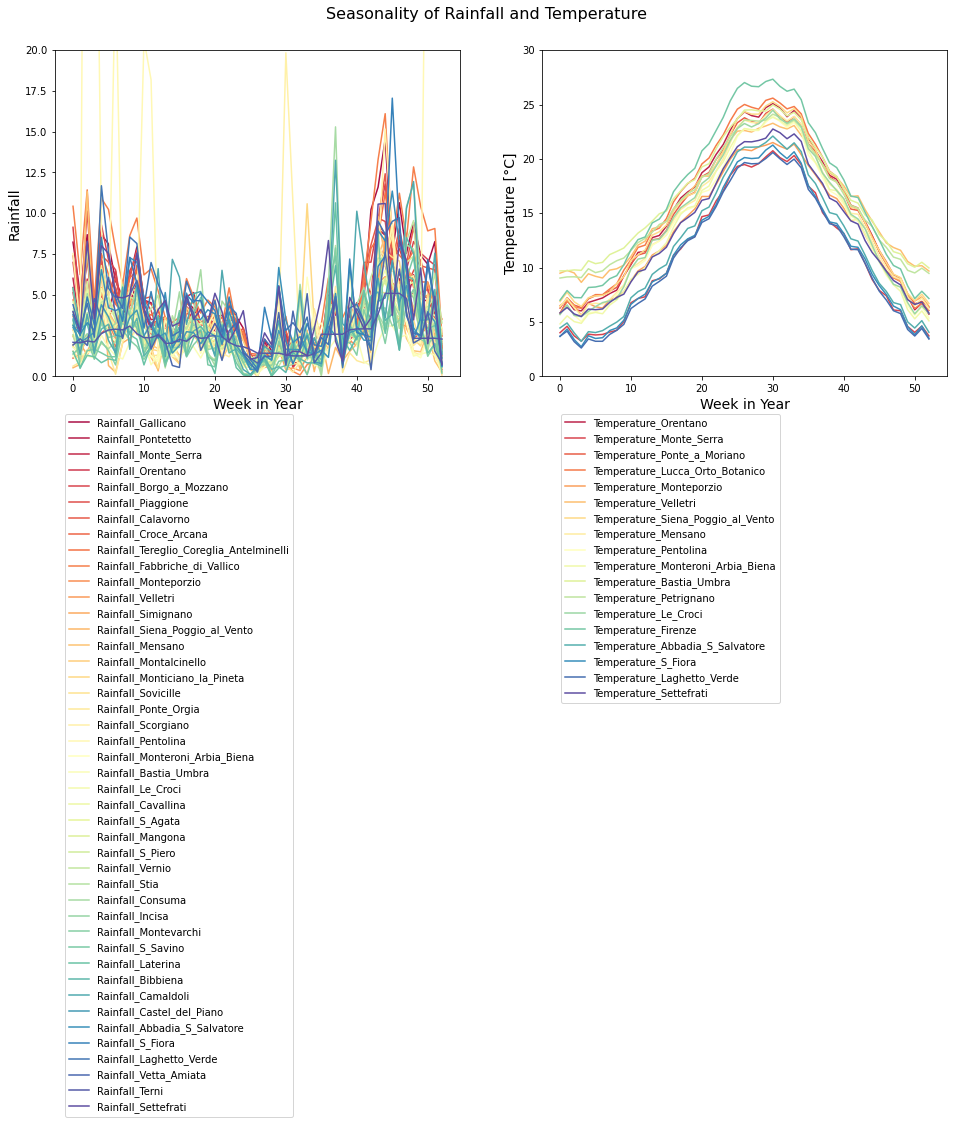

In [22]:
columns = waterbodies_df.columns[waterbodies_df.columns.str.startswith('Rainfall') | waterbodies_df.columns.str.startswith('Temperature')]

temp = waterbodies_df.groupby('week_in_year')[columns].mean().reset_index(drop=False)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
f.suptitle('Seasonality of Rainfall and Temperature', fontsize=16)

evenly_spaced_interval = np.linspace(0, 1, len(temp.columns[temp.columns.str.startswith('Rainfall')])+1)
colors = [cm.Spectral(x) for x in evenly_spaced_interval]
for i, col in enumerate(temp.columns[temp.columns.str.startswith('Rainfall')]):
    sns.lineplot(data=temp, x='week_in_year', y=col, ax=ax[0], label=col, color=colors[i+1])
ax[0].legend(bbox_to_anchor=(0.6, -0.1, 0, 0))
ax[0].set_ylabel('Rainfall', fontsize=14)
ax[0].set_xlabel('Week in Year', fontsize=14)
ax[0].set_ylim([0, 20])

evenly_spaced_interval = np.linspace(0, 1, len(temp.columns[temp.columns.str.startswith('Temperature')])+1)
colors = [cm.Spectral(x) for x in evenly_spaced_interval]
for i, col in enumerate(temp.columns[temp.columns.str.startswith('Temperature')]):
    sns.lineplot(data=temp, x='week_in_year', y=col, ax=ax[1], label=col, color=colors[i+1])
ax[1].legend(bbox_to_anchor=(0.6, -0.1, 0, 0))
ax[1].set_ylabel('Temperature [°C]', fontsize=14)
ax[1].set_xlabel('Week in Year', fontsize=14)  
ax[1].set_ylim([0, 30])

plt.show()

For Velletri, Settefrati, Pentolina, Monteroni Arbia Biena, Laghetto Verde, Le Croci, Abbadia San Salvatore, San Fiora, Bastia Umbra, Mensano, Orentano, Monte Serra, Monteporzio, and Siena Poggio al Vento, we have **both rainfall and temperature data**.

Water spring Lupa, could be the most challenging to predict since it only has two features (`Date` and `Rainfall_Terni`).

## Time-Shifted Relationship between Features
> It is of the utmost importance to notice that some features like rainfall and temperature, which are present in each dataset, don’t go alongside the date. Indeed, both **rainfall and temperature affect features like level, flow, depth to groundwater and hydrometry some time after it fell down**. This means, for instance, that rain fell on 1st January doesn’t affect the mentioned features right the same day but some time later. As we don’t know how many days/weeks/months later rainfall affects these features, this is another aspect to keep into consideration when analyzing the dataset.

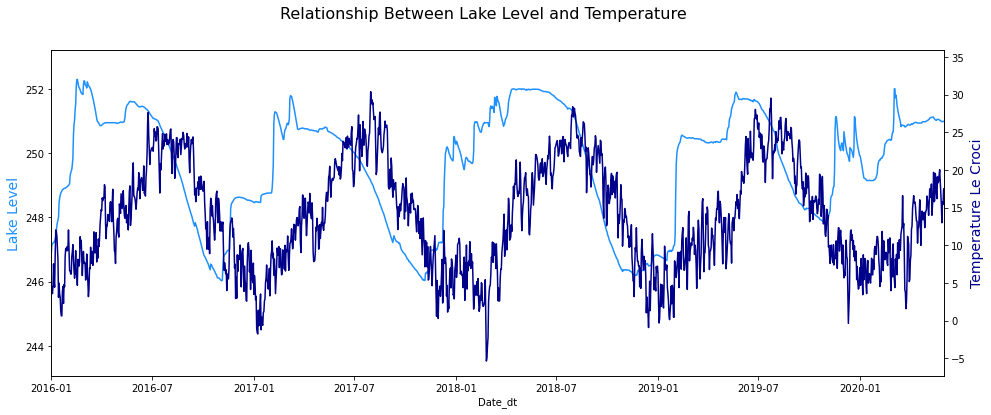

In [23]:
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
f.suptitle('Relationship Between Lake Level and Temperature', fontsize=16)
sns.lineplot(y=waterbodies_df.Lake_Level, x=waterbodies_df.Date_dt, ax=ax1, color='dodgerblue')
ax1.set_ylabel('Lake Level', color='dodgerblue', fontsize=14) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.lineplot(y=waterbodies_df.Temperature_Le_Croci, x=waterbodies_df.Date_dt, ax=ax2, color='darkblue')
ax2.set_ylabel('Temperature Le Croci', color='darkblue', fontsize=14) 

ax1.set_xlim([date(2016, 1, 1), date(2020, 6, 1)])

plt.show()



In [24]:
test = pd.read_excel("../input/acea-water-prediction/datasets_description.ods", engine="odf")

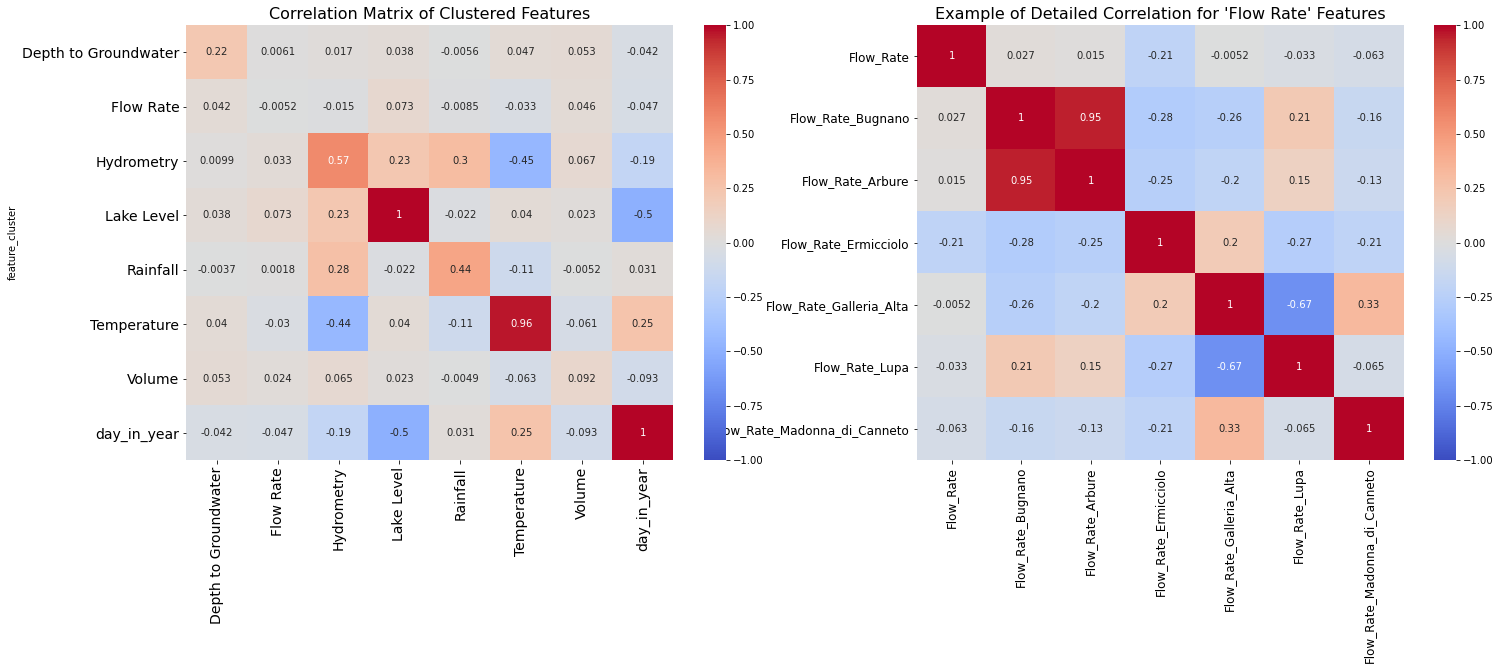

In [25]:
"""
## Clustered Correlation

There are many features with similar names in the datasets. To get a **first impression of the correlations between features**, we will cluster the features into rough categories and calculate the **mean correlations**. 

**This is not a correct representation of the underlying data** as it can be seen from the values on the diagonal axis which are not 1 as expected. For example, you can see that the the cluster 'Flow Rate' only has a correlation of 0.13 with itself. This is caused by high variation of correlations in the cluster as it can be seen in below right figure ('Example of Detailed Correlation for Flow Rate Features').

However, this is only intended for a rough overview. For a correct respresentation the the correlation between features, each feature has to be analysed separately. 
From the overview, we can see that **hydrometry is correlated to lake level, rainfall, temperature and season** (`day_in_year`). Additionally, **lake level and temperature seem to be seasonal** as well.
"""

sorted_cols = waterbodies_df.columns.sort_values()

temp = waterbodies_df[sorted_cols].corr()
clustered_cols = pd.Series(temp.index).apply(lambda x: get_column_category(x)).values

temp.index = clustered_cols

temp.columns = clustered_cols
temp = temp.reset_index(drop=False)
cols = temp.columns.values
cols[0] = 'feature_cluster'

temp.columns = cols
cols = [c for c in cols if c not in ['month', 'week_in_year', 'year']]
temp = temp[cols]
temp = temp.groupby('feature_cluster').median().T
temp = temp.reset_index(drop=False)
cols = temp.columns.values
cols[0] = 'feature_cluster'
temp.columns = cols
cols = [c for c in cols if c not in ['month', 'week_in_year', 'year']]
temp = temp[cols]
temp = temp.groupby('feature_cluster').median()
temp

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax[0].set_title('Correlation Matrix of Clustered Features', fontsize=16)

sns.heatmap(temp, vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax[0])

for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
    
    
sorted_cols = waterbodies_df.columns[waterbodies_df.columns.str.startswith('Flow')]

temp = waterbodies_df[sorted_cols].corr()

ax[1].set_title("Example of Detailed Correlation for 'Flow Rate' Features", fontsize=16)

sns.heatmap(temp, vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax[1])

for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.show()


# Aquifer
* Auser
* Amiata
* Petrifnano: fed by two underground aquifers
* Doganella: fed by two underground aquifers
* Luco: underground, not fed by rivers or lakes, fed by meteoric infiltration

# River
# Water Spring

# Waterbody: Lake
We can see that lake Bilancino and river Arno contain share a few locations. This is due to the **relationship between the lake Bilancino and the river Arno**. Lake Bilancino is an artificial lake made with a dam on the Sieve river. And the Sieve River is the most important tributary of the Arno river (see [Wikipedia: Lago di Bilancino](https://en.wikipedia.org/wiki/Lago_di_Bilancino), [Wikipedia: Sieve (river)]( https://en.wikipedia.org/wiki/Sieve_(river))).

* maximum depth of 31m
* surface 5$\text{m}^2$
> When the weather is dry, lake levels are often low and with abundant rain, lake levels generally rise. [1](http://www.sarasota.wateratlas.usf.edu/library/learn-more/learnmore.aspx?toolsection=lm_lakelevels)

In [26]:
waterbodies_df['month_in_year'] = waterbodies_df[['month', 'year']].apply(lambda x: date(x['year'], x.month, 1), axis=1)
waterbodies_df_monthly = waterbodies_df.groupby('month_in_year').mean().reset_index(drop=False)
waterbodies_df_monthly['month_in_year'] = pd.to_datetime(waterbodies_df_monthly['month_in_year'], format = '%Y-%m-%d')


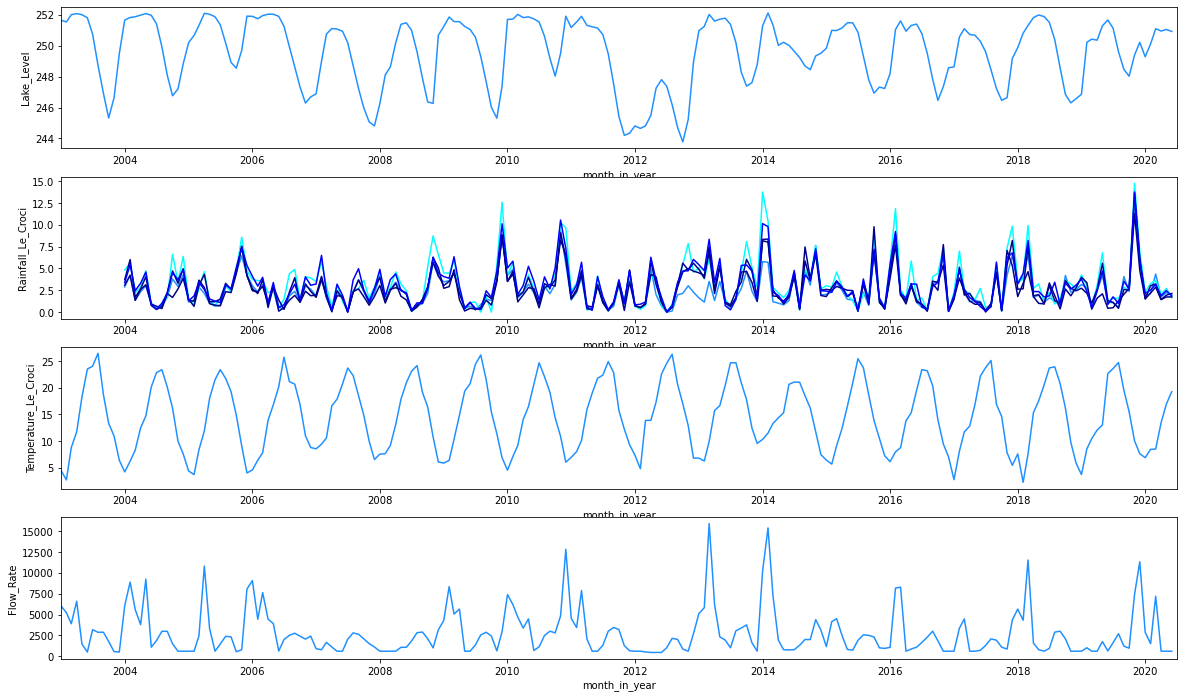

In [27]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))
sns.lineplot(data=waterbodies_df_monthly, y='Lake_Level', x='month_in_year', color='dodgerblue', ax=ax[0])
sns.lineplot(data=waterbodies_df_monthly, y='Rainfall_S_Piero', x='month_in_year', color='dodgerblue', ax=ax[1])
sns.lineplot(data=waterbodies_df_monthly, y='Rainfall_Mangona', x='month_in_year', color='aqua', ax=ax[1])
sns.lineplot(data=waterbodies_df_monthly, y='Rainfall_S_Agata', x='month_in_year', color='darkblue', ax=ax[1])
sns.lineplot(data=waterbodies_df_monthly, y='Rainfall_Cavallina', x='month_in_year', color='darkblue', ax=ax[1])
sns.lineplot(data=waterbodies_df_monthly, y='Rainfall_Le_Croci', x='month_in_year', color='blue', ax=ax[1])
sns.lineplot(data=waterbodies_df_monthly, y='Temperature_Le_Croci', x='month_in_year', color='dodgerblue', ax=ax[2])
sns.lineplot(data=waterbodies_df_monthly, y='Flow_Rate', x='month_in_year', color='dodgerblue', ax=ax[3])

for i in range(4):
    ax[i].set_xlim([date(2003, 1, 1), date(2020, 7, 1)])
plt.show()

# Work in Progress...

# References

## Literature
tbd

## Helpful Resources
* [this site](https://www.sir.toscana.it/consistenza-rete) 
* [Discussion: Features geolocation?](https://www.kaggle.com/c/acea-water-prediction/discussion/202797)
* [Discussion: For all attendees - Negative Flow rate](https://www.kaggle.com/c/acea-water-prediction/discussion/205071)
* [Wikipedia: Lago di Bilancino](https://en.wikipedia.org/wiki/Lago_di_Bilancino) 
* [Wikipedia: Sieve (river)]( https://en.wikipedia.org/wiki/Sieve_(river))


In [28]:
'''
## Seasonality

The challenge description gives us a hint about seasonality. Therefore, we will analyse the seasonality of the features in this section. For this purpose, we will **create time features: `year`, `month`, `day_in_year`, `week_in_year`.** 

> During fall and winter waterbodies are refilled, but during spring and summer they start to drain.


Before, we look at the seasonality, 






sns.heatmap(waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Rainfall')]].isna().astype(int),  
            cmap='binary', linewidth=0, vmin=0, vmax=1, ax=ax[0])
ax[0].set_ylabel('Row', fontsize=16)
ax[0].set_xlabel('Column', fontsize=16)
ax[0].set_title('Missing Rainfall Values', fontsize=16)

sns.heatmap((waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Rainfall')]] == 0).astype(int),  
            cmap='binary', linewidth=0, vmin=0, vmax=1, ax=ax[0])
ax[0].set_ylabel('Row', fontsize=16)
ax[0].set_xlabel('Column', fontsize=16)
ax[0].set_title('Zero Rainfall Values', fontsize=16)





f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.set_title(f'Rolling Mean Temperatures for {target} \n(Rolling Window: 28 Days, RSME: {mean_squared_error(y, y_oof)})', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Lake_Level, label='Ground Truth', color='dodgerblue')
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()



aquifer_auser_df 
aquifer_doganella_df 
aquifer_luco_df
aquifer_petrignano_df
lake_biliancino_df
river_arno_df
water_spring_amiata_df
water_spring_lupa_df
water_spring_madonna_df

'''

"""
(Next, we will **cluster the locations by KMeans** according to their coordinates and plot them on a map. -> don't really see the meaning of this)

geolocator = Nominatim(user_agent='myapplication')

city_locations_df = pd.DataFrame(columns=['city', 'lat', 'lon'] )
for city in waterbodies_df.columns[waterbodies_df.columns.str.startswith('Temperature')]:
    city = city.split('Temperature_')[1]
        
    city_dict = {}
    city_dict['city'] = city

    city = re.sub('_', ' ', city)
    city = re.sub('S ', 'San ', city)

    try:
        location = geolocator.geocode(f"{city}, Italy")
        city_dict['lat'] = location.raw['lat']
        city_dict['lon'] = location.raw['lon']
    except:
        # Manual coordinates for missing cities:
        if city == 'Monteroni Arbia Biena':
            city_dict['lat'] = 43.228279
            city_dict['lon'] = 11.4021433
    
    # Manual coordinates for wrong locations:
    if city == 'Monte Serra':
        city_dict['lat'] = 43.750833
        city_dict['lon'] = 10.555278
    elif city == 'Laghetto Verde':
        city_dict['lat'] = 44.5104966
        city_dict['lon'] = 10.4032786
    elif city == 'Le Croci':
        city_dict['lat'] = 44.0360503
        city_dict['lon'] = 11.2675661
    elif city == 'San Agata':
        city_dict['lat'] = 43.9438247
        city_dict['lon'] = 11.3089835    
    elif city == 'San Piero':
        city_dict['lat'] = 43.9637372
        city_dict['lon'] = 11.3182991
    city_locations_df = city_locations_df.append(city_dict, ignore_index=True)

for city in waterbodies_df.columns[waterbodies_df.columns.str.startswith('Rainfall')]:
    city = city.split('Rainfall_')[1]

    city_dict = {}
    city_dict['city'] = city
    
    city = re.sub('_', ' ', city)
    city = re.sub('S ', 'San ', city)

    try:
        location = geolocator.geocode(f"{city}, Italy")
        city_dict['lat'] = location.raw['lat']
        city_dict['lon'] = location.raw['lon']
    except:
        # print(f'Could not find coordinates for {city}')
        # Manual coordinates for missing cities:
        if city == 'Monticiano la Pineta':
            city_dict['lat'] = 43.1335066
            city_dict['lon'] = 11.2408464
        elif city == 'Ponte Orgia':
            city_dict['lat'] = 43.2074581
            city_dict['lon'] = 11.2504416
        elif city == 'Monteroni Arbia Biena':
            city_dict['lat'] = 43.228279
            city_dict['lon'] = 11.4021433
            
    # Manual coordinates for wrong locations:
    if city == 'Monte Serra':
        city_dict['lat'] = 43.750833
        city_dict['lon'] = 10.555278
    elif city == 'Laghetto Verde':
        city_dict['lat'] = 44.5104966
        city_dict['lon'] = 10.4032786 
    elif city == 'Le Croci':
        city_dict['lat'] = 44.0360503
        city_dict['lon'] = 11.2675661
    elif city == 'San Agata':
        city_dict['lat'] = 43.9438247
        city_dict['lon'] = 11.3089835    
    elif city == 'San Piero':
        city_dict['lat'] = 43.9637372
        city_dict['lon'] = 11.3182991
            
    city_locations_df = city_locations_df.append(city_dict, ignore_index=True)

# Cities with both temperature and rainfall data
#temp = city_locations_df.city.value_counts().to_frame()
#print(list(temp[temp.city==2].index.values))

city_locations_df = city_locations_df.sort_values(by='city').drop_duplicates().reset_index(drop=True)
city_locations_df.lat = city_locations_df.lat.astype(float)
city_locations_df.lon = city_locations_df.lon.astype(float)

# Cluster locations
N_CLUSTERS = 12
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit(city_locations_df[['lat', 'lon']]) #1
city_locations_df['cluster'] = kmeans.labels_

# Re-arrange clusters by lat/lon
city_locations_df['cluster_center_lat'] = city_locations_df['cluster'].apply(lambda x: kmeans.cluster_centers_[x,0])
city_locations_df['cluster_center_lon'] = city_locations_df['cluster'].apply(lambda x:kmeans.cluster_centers_[x, 1])
city_locations_df = city_locations_df.sort_values(by='cluster').reset_index(drop=True)
city_locations_df = city_locations_df.sort_values(by=['cluster_center_lat','cluster_center_lon']).reset_index(drop=True)

# Rename clusters in order 
cluster_dict = {}
for old, new in enumerate(city_locations_df.cluster.unique()):
    cluster_dict[new] = old

city_locations_df.cluster = city_locations_df.cluster.replace(cluster_dict)

# Plot on map
m = folium.Map(location=[41.8719, 12.5674], tiles='cartodbpositron',zoom_start=7)

colors = ['beige', 'orange','pink', 'lightred','red',  'darkred','purple','darkpurple', 
          'lightblue', 'cadetblue', 'blue', 'darkblue',
         'lightgreen', 'green', 'darkgreen', 'black', 'gray','lightgray', 'white']


geolocator = Nominatim(user_agent='myapplication')
for i in city_locations_df.index:
    folium.Marker([city_locations_df.iloc[i].lat, 
                  city_locations_df.iloc[i].lon],
                  popup=city_locations_df.iloc[i].city, 
                  icon=folium.Icon(color=colors[city_locations_df.iloc[i].cluster])).add_to(m)

m


"""





# Next, we will calculate the **distances between the locations with the haversine formula** and verify the clusters.

# TODO: Maybe not relevant information - Think about removing this again
"""
def haversine(lon1, lat1, lon2, lat2):
    # Function copied from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    # Calculate the great circle distance between two points 
    # on the earth (specified in decimal degrees)

    R = 6372.8 # Earth radius in kilometers

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return round(R * c, 0)

distances = np.zeros((len(city_locations_df.index), len(city_locations_df.index)))
for i in (city_locations_df.index):
    for j in city_locations_df.index:
        distances[i, j] = haversine(city_locations_df.iloc[i].lon, 
                                    city_locations_df.iloc[i].lat, 
                                    city_locations_df.iloc[j].lon, 
                                    city_locations_df.iloc[j].lat)

distances_df = pd.DataFrame(columns = city_locations_df.city.values, index= city_locations_df.city.values, data=distances)



f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
ax.set_title('Clustered Distances between Locations [km]', fontsize=16)
sns.heatmap(distances_df, cmap='Blues')
ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 0
ax.add_patch(Rectangle((1, 1), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 1
ax.add_patch(Rectangle((2, 2), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 2
ax.add_patch(Rectangle((3, 3), 2, 2, fill=False, alpha=1, color='Black', lw=2)) # Cluster 3
ax.add_patch(Rectangle((5, 5), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 4
ax.add_patch(Rectangle((6, 6), 3, 3, fill=False, alpha=1, color='Black', lw=2)) # Cluster 5
ax.add_patch(Rectangle((9, 9), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 6
ax.add_patch(Rectangle((10, 10), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 7
ax.add_patch(Rectangle((11, 11), 10, 10, fill=False, alpha=1, color='Black', lw=2)) # Cluster 8
ax.add_patch(Rectangle((21, 21), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 9
ax.add_patch(Rectangle((22, 22), 3, 3, fill=False, alpha=1, color='Black', lw=2)) # Cluster 10
ax.add_patch(Rectangle((25, 25), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 11
ax.add_patch(Rectangle((26, 26), 4, 4, fill=False, alpha=1, color='Black', lw=2)) # Cluster 12
ax.add_patch(Rectangle((30, 30), 5, 5, fill=False, alpha=1, color='Black', lw=2)) # Cluster 13
ax.add_patch(Rectangle((35, 35), 4, 4, fill=False, alpha=1, color='Black', lw=2)) # Cluster 14
ax.add_patch(Rectangle((39, 39), 7, 7, fill=False, alpha=1, color='Black', lw=2)) # Cluster 15
ax.add_patch(Rectangle((46, 46), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 16
ax.add_patch(Rectangle((47, 47), 1, 1, fill=False, alpha=1, color='Black', lw=2)) # Cluster 17

plt.show()

"""

"\ndef haversine(lon1, lat1, lon2, lat2):\n    # Function copied from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points\n    # Calculate the great circle distance between two points \n    # on the earth (specified in decimal degrees)\n\n    R = 6372.8 # Earth radius in kilometers\n\n    dLat = radians(lat2 - lat1)\n    dLon = radians(lon2 - lon1)\n    lat1 = radians(lat1)\n    lat2 = radians(lat2)\n\n    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2\n    c = 2*asin(sqrt(a))\n\n    return round(R * c, 0)\n\ndistances = np.zeros((len(city_locations_df.index), len(city_locations_df.index)))\nfor i in (city_locations_df.index):\n    for j in city_locations_df.index:\n        distances[i, j] = haversine(city_locations_df.iloc[i].lon, \n                                    city_locations_df.iloc[i].lat, \n                                    city_locations_df.iloc[j].lon, \n                                    city_loca